(mmm_intro_upper_funnel)=
# Introduction: Measuring Upper-Funnel Impact with PyMC‑Marketing

In this notebook, we will walk through a simple example of how to use PyMC-Marketing to measure the impact of upper-funnel channels on a downstream business outcome. A very detailed and advanced version of this notebook is available in {ref}`mmm_upper_funnel_causal_approach`.


## Business Challenge

Upper-funnel marketing investments (awareness campaigns, video ads, influencer partnerships) rarely drive immediate conversions. Leadership often asks: *"Are our upper-funnel dollars doing anything?"* Standard dashboards show weak direct correlations with sales, making these channels appear ineffective.

The challenge is that **upper-funnel channels work indirectly**. They build awareness that flows through mid-funnel engagement and eventually reaches high-intent channels (like brand search) that directly drive outcomes. Ignoring this mediation structure either under-credits upper-funnel impact or incorrectly attributes all lift to the final touchpoint.

**This notebook shows how to:**
- Respect the causal structure of the marketing funnel
- Measure indirect effects through mediation modeling
- Generate counterfactual predictions to quantify upper-funnel impact

For a detailed treatment including data generation and theoretical foundations, see {ref}`mmm_upper_funnel_causal_approach`.

```{tip}
This approach is very similar to the one presented in the blog post [Bayesian Media Mix Modeling using PyMC3, for Fun and Profit](https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6) by [HelloFresh](https://engineering.hellofresh.com/).
```
```{note}
Funnel effects in marketing mix modeling are well-known, but not clearly explained how to tackle them with causal inference. Here, we want to bridge this gap.

For instance, already in the well-known paper [Challenges and Opportunities in Media Mix Modeling](https://research.google/pubs/challenges-and-opportunities-in-media-mix-modeling/), by D. Chan, et al., (Google) they mention:

*Selection bias arises when there are funnel effects in the media and the model is mis-specified. When
an ad channel also impacts the level of another ad channel
which simultaneously estimate the impact of all ad channels in one equation, will lead to biased
estimates. An example is a TV campaign driving more related queries, which in turn increase
volume of paid search ads. For a derivation of the size of the bias, see Angrist and Krueger (1999).
The underlying reason for the bias in the mis-specified model is that the downstream ads were
affected by the TV ads. In assessing the ROAS of TV, the linear regression model does not account
for the changes in paid search ads caused by TV.
Downstream ads should not be included with exogenously-determined ads in a single regression
equation. Alternatives include graphical models (Pearl (2009)) and structural equation models.
However, the problem isn’t only a matter of model form. Both these alternatives require estimating
the causal effect of the upstream ads on the downstream ads, which has just as stringent data
requirements as estimating the effect of an ad channel on sales.*
```

## Prepare Notebook

In [1]:
import arviz as az
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pymc_extras.prior import Prior

from pymc_marketing.mmm import (
    GeometricAdstock,
    MichaelisMentenSaturation,
    NoAdstock,
    NoSaturation,
)
from pymc_marketing.mmm.dims import Censored
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

SEED = 142
rng = np.random.default_rng(SEED)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juan.orduz/.local/share/mamba/envs/pymc-marketing-env/lib/python3.13/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort
/Users/juan.orduz/Documents/pymc-marketing/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors
/Users/juan.orduz/Documents/pymc-marketing/pymc_marketing/mmm/multidimensional.py:216: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


## Read Data

Let's consider a simple example where we have a downstream business outcome (new users) and a set of upper-funnel channels (`impressions_x1`, `impressions_x2`, `impressions_x3`, `impressions_x4`) (this synthetic data is generated in the advanced version of this notebook {ref}`mmm_upper_funnel_causal_approach`).

In [2]:
data = pd.read_csv(data_dir / "funnel_data.csv", parse_dates=["date"])

data.head()

,date,target_var,impressions_x1,impressions_x2,impressions_x3,impressions_x4,event_2020_09,event_2020_12,event_2021_09,event_2021_12,event_2022_09,trend
0,2022-01-01,0.4966,0.1577,0.1194,0.2208,0.1134,0.0,0.0,0.0,0.0,0.0,0
1,2022-01-02,0.5341,0.1394,0.1169,0.2263,0.1157,0.0,0.0,0.0,0.0,0.0,1
2,2022-01-03,0.5659,0.1712,0.1177,0.2268,0.1240,0.0,0.0,0.0,0.0,0.0,2
3,2022-01-04,0.5761,0.1175,0.1163,0.2247,0.1221,0.0,0.0,0.0,0.0,0.0,3
4,2022-01-05,0.5679,0.0927,0.1177,0.2209,0.1156,0.0,0.0,0.0,0.0,0.0,4


Let's look at the data:

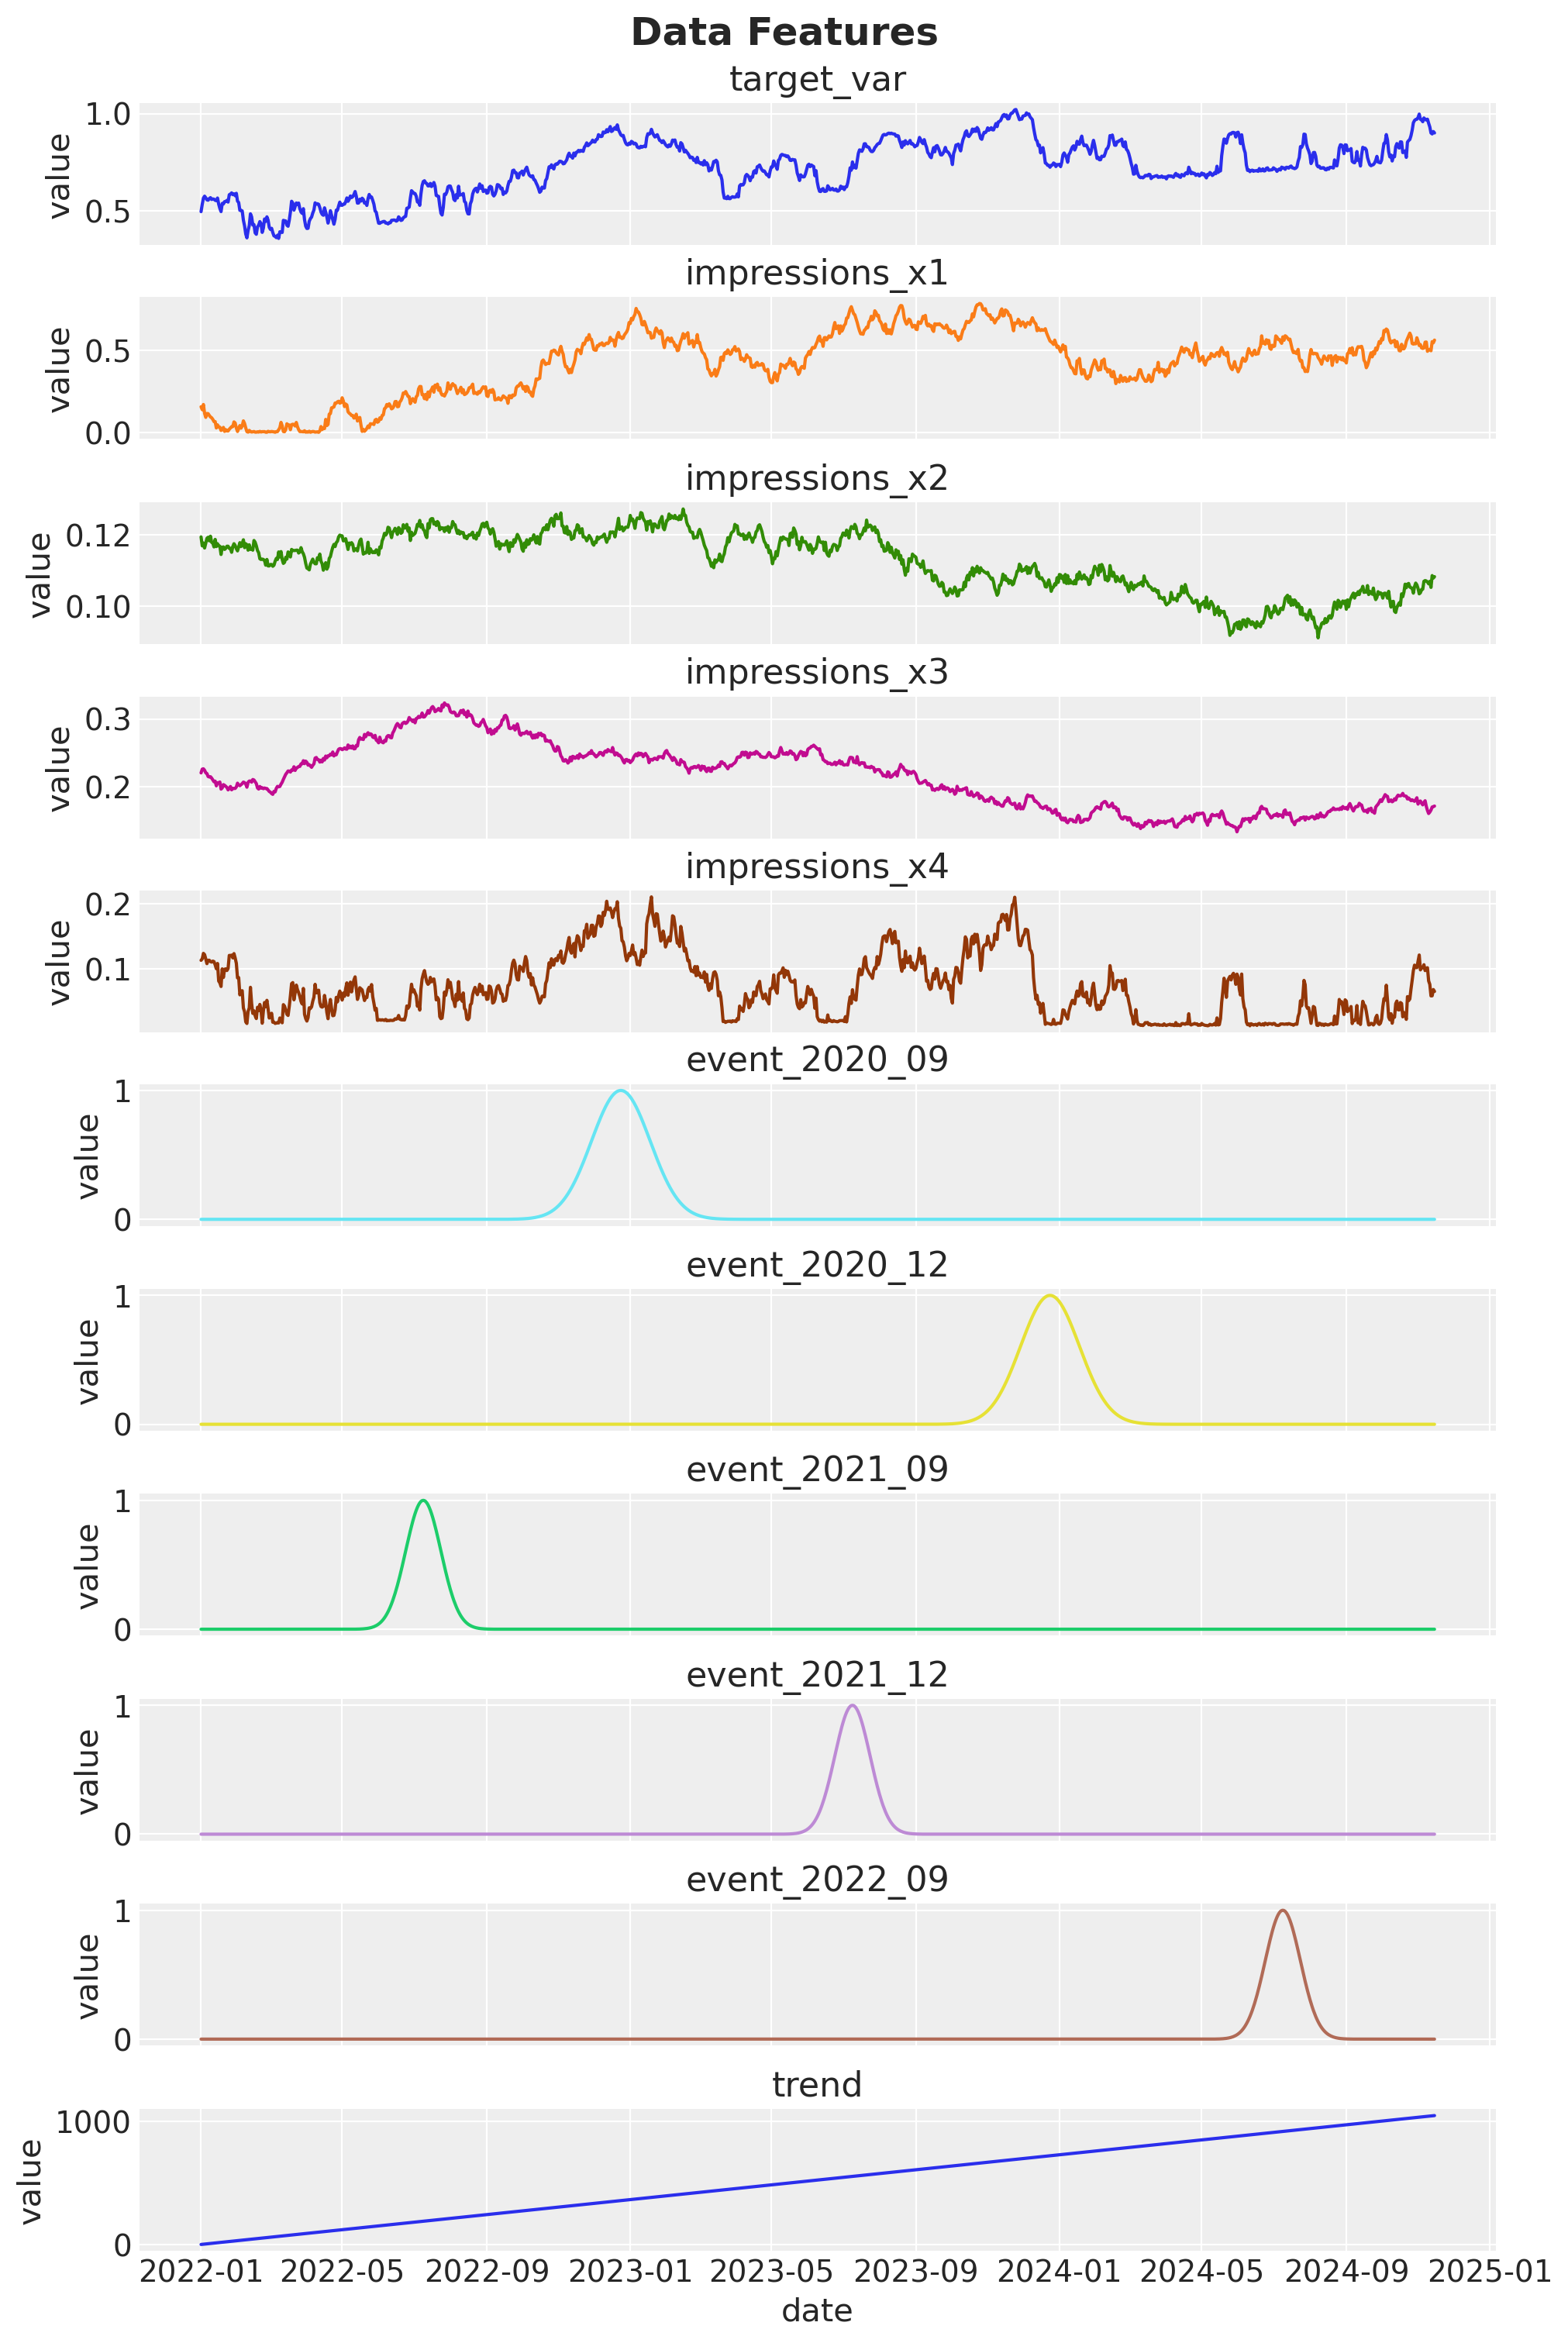

In [3]:
fig, axes = plt.subplots(
    nrows=data.shape[1] - 1,
    figsize=(10, 15),
    sharex=True,
    sharey=False,
    layout="constrained",
)

variables = data.columns.drop("date")

for i, variable in enumerate(variables):
    sns.lineplot(data=data, x="date", y=variable, color=f"C{i}", ax=axes[i])
    axes[i].set(title=variable, ylabel="value")

fig.suptitle("Data Features", fontsize=18, fontweight="bold");

- We have a `target_var` that we want to predict.
- We have 4 upper-funnel channels: `impressions_x1`, `impressions_x2`, `impressions_x3`, `impressions_x4`.
- We have some control variables: `holidays`, `trend`, `event_2020_09`, `event_2020_12`, `event_2021_09`, `event_2021_12`, `event_2022_09` (events look like Gaussian bumps).





Let us visualize the impressions data in detail:

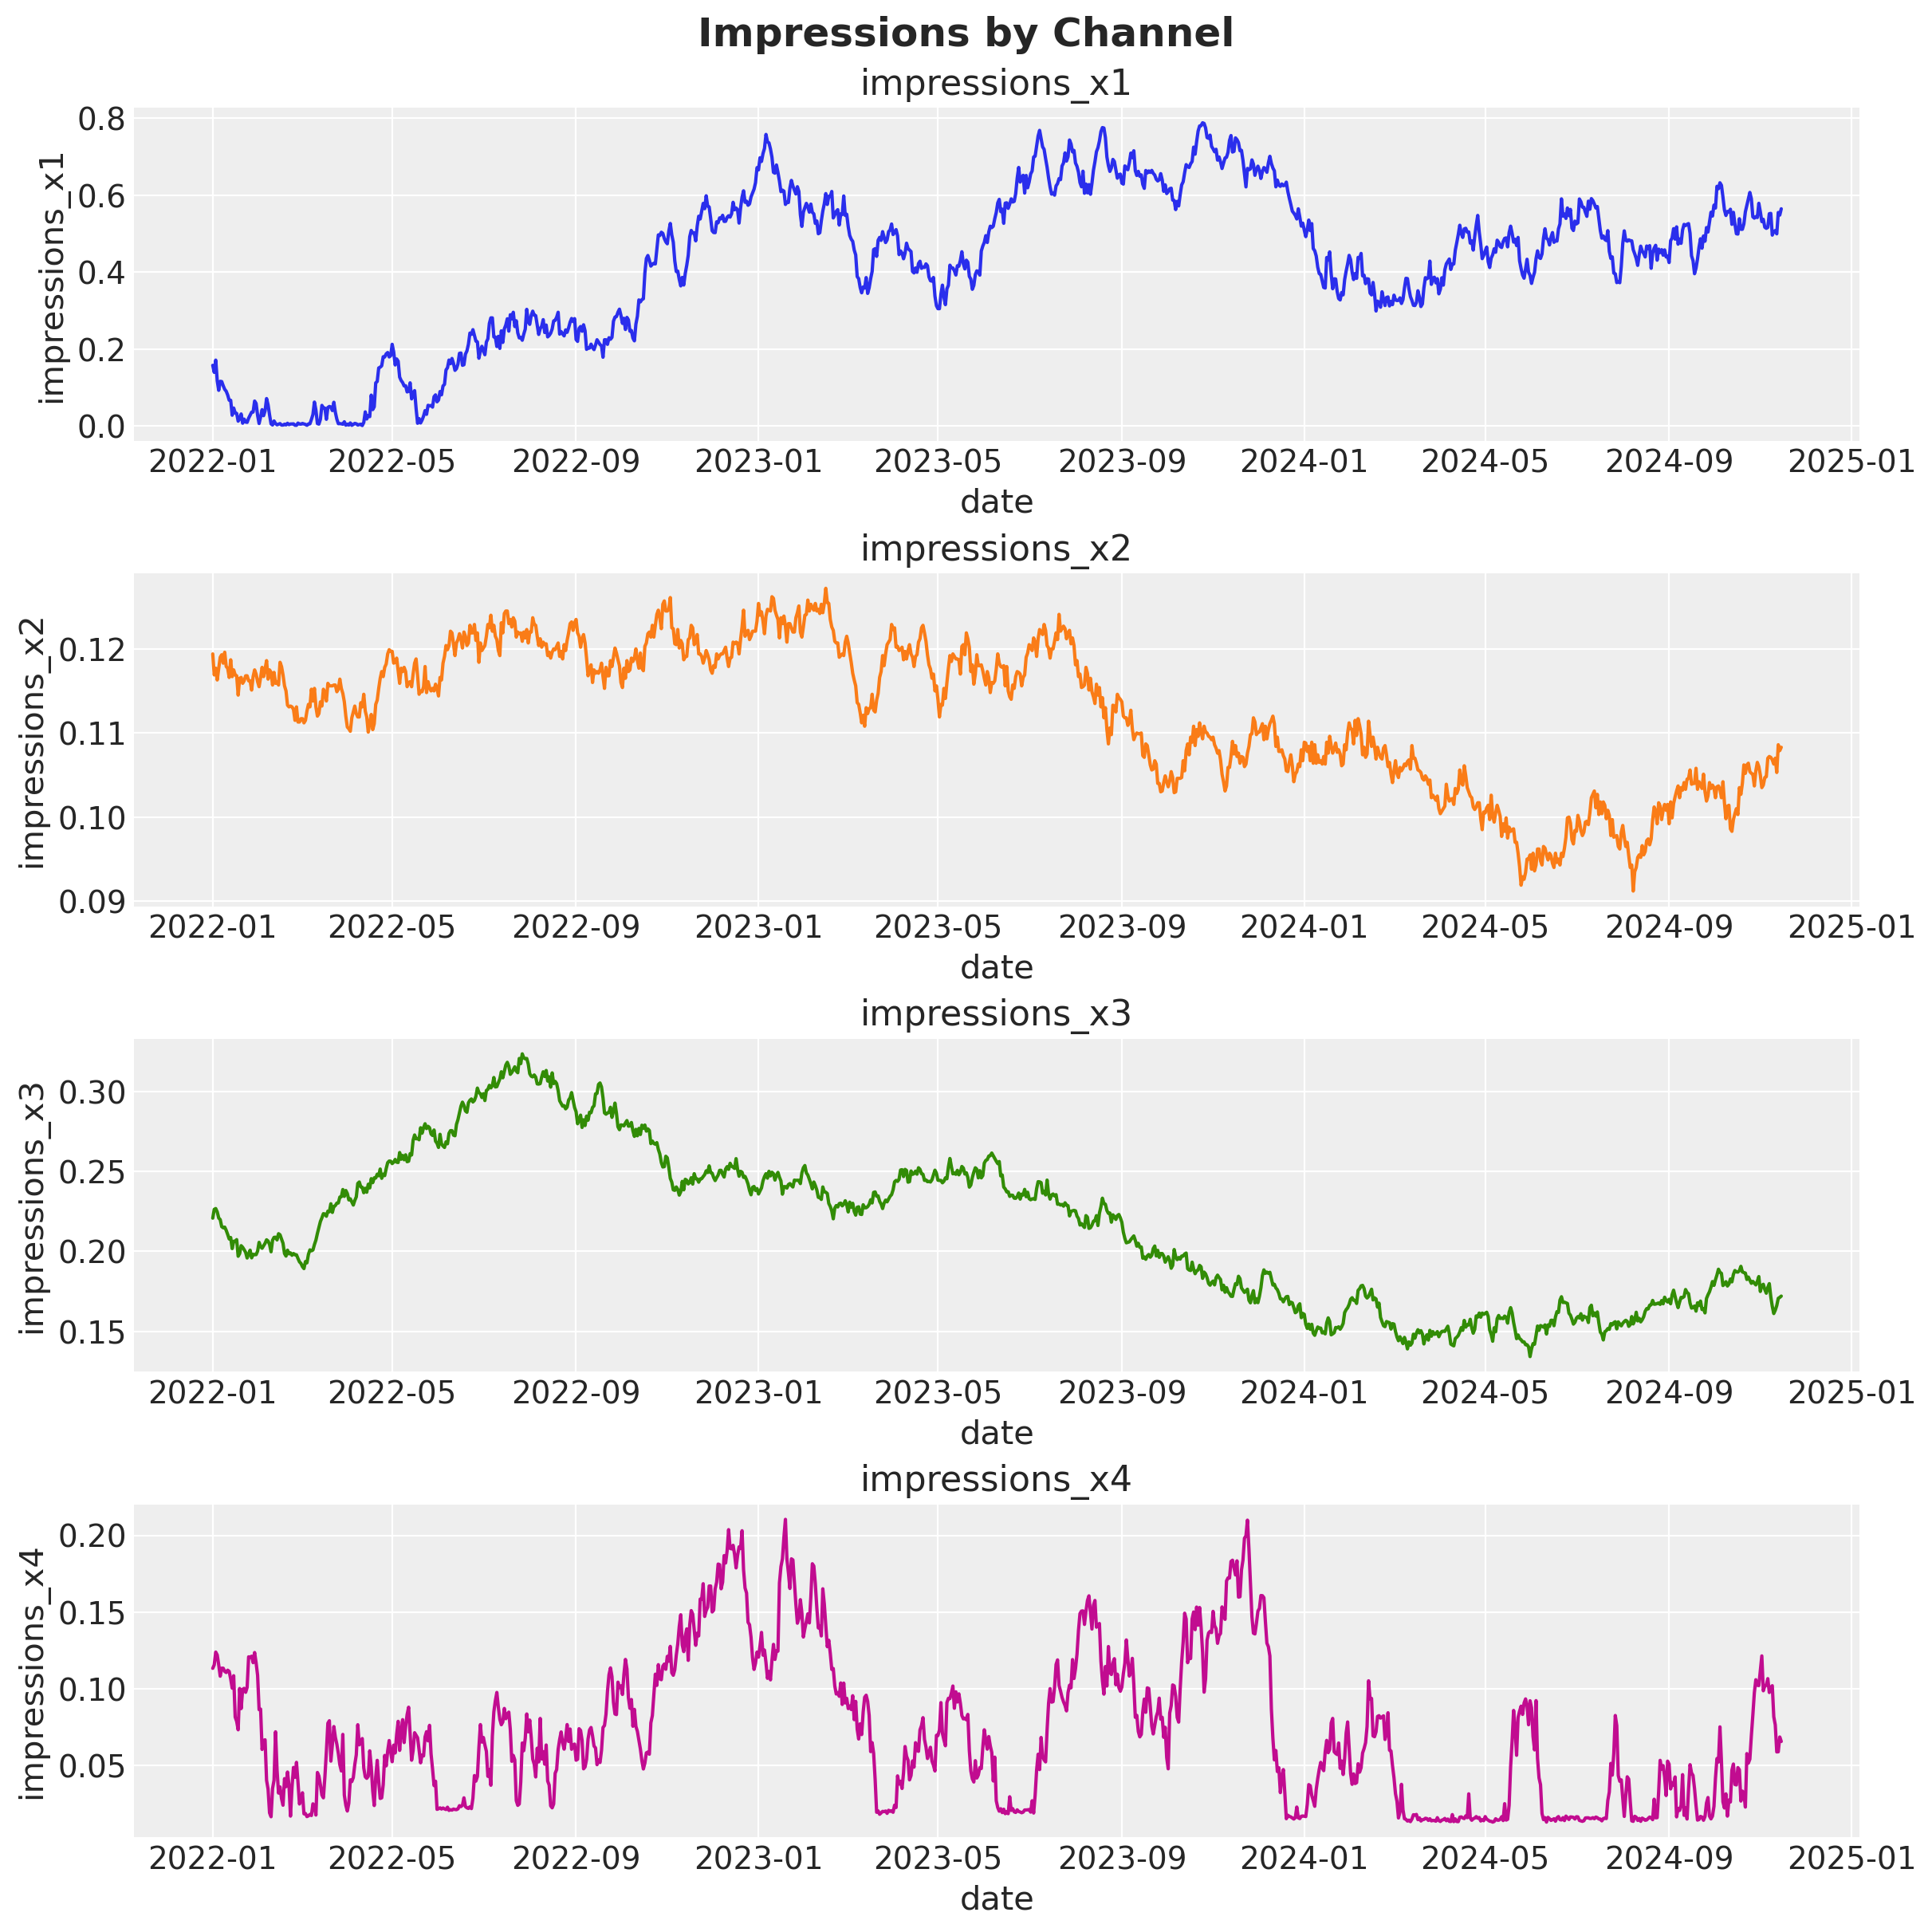

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))

channel_columns = [f"impressions_x{i}" for i in range(1, 5)]

for i, channel in enumerate(channel_columns):
    sns.lineplot(data=data, x="date", y=channel, color=f"C{i}", ax=ax[i])
    ax[i].set(title=channel)

fig.suptitle("Impressions by Channel", fontsize=18, fontweight="bold");

## Causal DAG

As described in the introduction, understanding the causal structure of the marketing funnel is key to correctly attribute the effect of each channel. A simple, put-all-channels-in-one-model approach will lead to biased estimates (see {ref}`mmm_upper_funnel_causal_approach` for a comparison).

A common and handy structure to encode causal relationships is the causal directed acyclic graph (DAG). Each node represents a variable, and each arrow represents a causal relationship. This DAG does not come from the data, but rather from our understanding of the marketing funnel for the concrete application (one can use causal discovery methods to learn some structure of the DAG from the data, but that is out of scope for this notebook, see {ref}`mmm_causal_reasoning_and_discovery`).

The DAG below shows our hypothesis about the structure of our marketing funnel. This diagram represents our understanding of how marketing channels influence each other and ultimately drive the outcome.

**Key components:**

- **X1 (impressions_x1)**: Upper-funnel awareness channel (e.g., video, display ads)
- **X2, X3 (impressions_x2, impressions_x3)**: Mid-funnel consideration channels (social engagement, remarketing)
- **X4 (impressions_x4)**: Lower-funnel high-intent channel (brand search)
- **Y (new users)**: Business outcome
- **U1, U2, U3, U4**: Exogenous factors affecting each channel (unobserved)

**The funnel structure:**

$$X_1 \to (X_2, X_3) \to X_4 \to Y$$

Notice that **X1 does not directly affect Y**. Its influence flows entirely through the downstream channels. This mediation structure is critical: if we model all channels as directly affecting Y (the "throw everything in" approach), we'll misattribute effects and either over- or under-credit upper-funnel investments.

The dashed nodes represent unobserved factors (holidays, budget changes, competitor actions) that can shift channels independently.


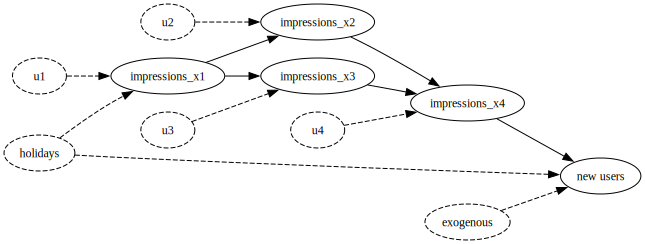

In [5]:
# Create the causal DAG
causal_dag = graphviz.Digraph("causal_dag")
causal_dag.attr(rankdir="LR")
causal_dag.attr("node", fontsize="12")

# Observed nodes
causal_dag.node("x1", "impressions_x1")
causal_dag.node("x2", "impressions_x2")
causal_dag.node("x3", "impressions_x3")
causal_dag.node("x4", "impressions_x4")
causal_dag.node("holidays", "holidays", shape="ellipse", style="dashed")
causal_dag.node("exogenous", "exogenous", shape="ellipse", style="dashed")
causal_dag.node("y", "new users")

# Exogenous vectors (unobserved)
causal_dag.node("u1", shape="ellipse", style="dashed")
causal_dag.node("u2", shape="ellipse", style="dashed")
causal_dag.node("u3", shape="ellipse", style="dashed")
causal_dag.node("u4", shape="ellipse", style="dashed")

# Exogenous parents
causal_dag.edge("u1", "x1", style="dashed")
causal_dag.edge("u2", "x2", style="dashed")
causal_dag.edge("u3", "x3", style="dashed")
causal_dag.edge("u4", "x4", style="dashed")

# Structural edges with coefficient labels
causal_dag.edge("x1", "x2")
causal_dag.edge("x1", "x3")
causal_dag.edge("x2", "x4")
causal_dag.edge("x3", "x4")

# add x4 to y, and holidays to y, and exogenous to y
causal_dag.edge("x4", "y")
causal_dag.edge("holidays", "y", style="dashed")
causal_dag.edge("exogenous", "y", style="dashed")

# holiday to x1
causal_dag.edge("holidays", "x1", style="dashed")

causal_dag

To measure the indirect effect of X1 (upper funnel) on Y (outcome), we use a **two-model approach**:

1. **Direct Model (Outcome Model)**: Estimates how X4 (lower funnel) affects Y
   - Includes adstock (carryover effects) and saturation (diminishing returns)
   - Only models the final step: $X_4 \to Y$

2. **Indirect Model (Mediation Model)**: Estimates how X1 (upper funnel) affects X4 (lower funnel)
   - Captures the propagation through the funnel: $X_1 \to X_4$
   - Uses simpler transformations since this link is more direct

By separating these two relationships, we can:
- Respect the causal structure from our DAG
- Avoid confounding the indirect path with the direct effect
- Generate counterfactuals to ask "what if X1 had been zero?"

**Why not just include all channels in one model?** Because that approach ignores mediation. It would try to estimate a direct $X_1 \to Y$ effect (which doesn't exist in our causal story) and would misattribute the propagated effect through $X_4$.

## Data Preparation

We split the data into training and test sets to evaluate how well our causal model generalizes. The training set will be used to fit both our outcome model and our mediation model.

In [6]:
# Split data into train and test sets
train_idx = 879


X_train = data.iloc[:train_idx].drop(columns=["target_var"])
X_test = data.iloc[train_idx:].drop(columns=["target_var"])
y_train = data.iloc[:train_idx]["target_var"]
y_test = data.iloc[train_idx:]["target_var"]

**Control columns** include trend and event indicators. These represent factors that affect the outcome but are not marketing channels (holidays, seasonality, special events). Including them ensures we don't misattribute their effects to our channels.

In [7]:
control_columns = [
    "event_2020_09",
    "event_2020_12",
    "event_2021_09",
    "event_2021_12",
    "event_2022_09",
    "trend",
]

## Model Specification

Now we are ready to specify both models in PyMC-Marketing.

### Direct Model

The first model captures how the **lower-funnel channel (X4) drives the outcome (Y)**. This is the most direct relationship in our funnel and includes the dynamic effects we expect in marketing:

**Adstock (Geometric)**: Marketing effects don't disappear immediately. Today's exposure influences tomorrow's outcome with some decay rate $\alpha$. The `l_max=24` parameter means we allow up to $24$ days of carryover.

**Saturation (Michaelis-Menten)**: Returns diminish as exposure increases. The first $1,000$ impressions might drive $100$ conversions, but the next $1,000$ might only drive $50$. Parameters $\lambda$ and $\alpha$ control the shape of this curve.

We model only X4 → Y here because, according to our DAG, X4 is the **sole marketing mediator** between all upstream channels and the outcome. By getting this relationship right first, we can later propagate upstream effects through it.


In [8]:
adstock_priors = {
    "alpha": Prior("Beta", alpha=1, beta=1, dims="channel"),
}

adstock = GeometricAdstock(l_max=24, priors=adstock_priors)

saturation_priors = {
    "lam": Prior(
        "Gamma",
        mu=2,
        sigma=2,
        dims="channel",
    ),
    "alpha": Prior(
        "Gamma",
        mu=1,
        sigma=1,
        dims="channel",
    ),
}

saturation = MichaelisMentenSaturation(priors=saturation_priors)

In [9]:
# Model config
model_config = {
    "likelihood": Censored(
        Prior(
            "Normal",
            sigma=Prior("HalfNormal", sigma=1),
            dims="date",
        ),
        lower=0,
    )
}

# sampling options for PyMC
sample_kwargs = {
    "tune": 1_500,
    "draws": 1_000,
    "chains": 4,
    "random_seed": SEED,
    "target_accept": 0.9,
    "nuts_sampler": "numpyro",
}

In [10]:
first_causal_mmm = MMM(
    date_column="date",
    target_column="target_var",
    channel_columns=["impressions_x4"],
    control_columns=control_columns,
    adstock=adstock,
    saturation=saturation,
    model_config=model_config,
    sampler_config=sample_kwargs,
)

first_causal_mmm.build_model(X_train, y_train)

first_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)

first_causal_mmm.fit(
    X_train,
    y_train,
)

_ = first_causal_mmm_posterior_predictive = (
    first_causal_mmm.sample_posterior_predictive(
        X_train, extend_idata=True, combined=True
    )
)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]


Output()

### Indirect Model

The second model captures how **upper-funnel activity (X1) influences lower-funnel exposure (X4)**. This is the mediation link that allows us to trace indirect effects.

**Why use differences?** 

If X1 and X4 are both trending or have unit roots (common in marketing time series), a levels-on-levels regression $(X_{4,t} = \alpha + \beta X_{1,t} + \varepsilon_t)$ can produce spurious correlations. Taking first differences removes trends and gives us a stationary relationship:

$$\Delta X_{4,t} = \beta \cdot \Delta X_{1,t} + \varepsilon_t$$

or equivalently:

$$X_{4,t} - X_{4,t-1} = \beta \cdot (X_{1,t} - X_{1,t-1})$$

This estimates the **instantaneous propagation**: when X1 increases by 1 unit, how much does X4 change?

**No adstock or saturation here.** We're assuming the X1 → X4 link is approximately linear and immediate. All the nonlinear dynamics (saturation, carryover) happen in the X4 → Y step, which we already modeled above. This simplification keeps the mediation model interpretable.


In [11]:
# Take first difference of the data
X_train["impressions_x1_diff"] = X_train["impressions_x1"].diff()
X_train["impressions_x4_diff"] = X_train["impressions_x4"].diff()

Let's fit the mediation model:

In [12]:
second_causal_mmm = MMM(
    date_column="date",
    target_column="impressions_x4_diff",
    channel_columns=["impressions_x1_diff"],
    adstock=NoAdstock(
        l_max=1
    ),  # We remove the adstock because we want to estimate the causal effect of x1 on x4 which is purely linear
    saturation=NoSaturation(
        priors={"beta": Prior("Gamma", mu=0.7, sigma=0.4)}
    ),  # linear beta
    sampler_config=sample_kwargs,
)

second_causal_mmm.build_model(
    X_train.drop(columns=["impressions_x4_diff"]),
    X_train["impressions_x4_diff"],
)

second_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)

second_causal_mmm.fit(
    X_train.drop(columns=["impressions_x4_diff"]),
    X_train["impressions_x4_diff"],
)

_ = second_causal_mmm.sample_posterior_predictive(
    X_train.drop(columns=["impressions_x4_diff"]),
    extend_idata=True,
    combined=True,
)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Output()

Sampling: [y]


Output()

For the sake of comparison, let's plot the posterior distribution of the saturation parameter:

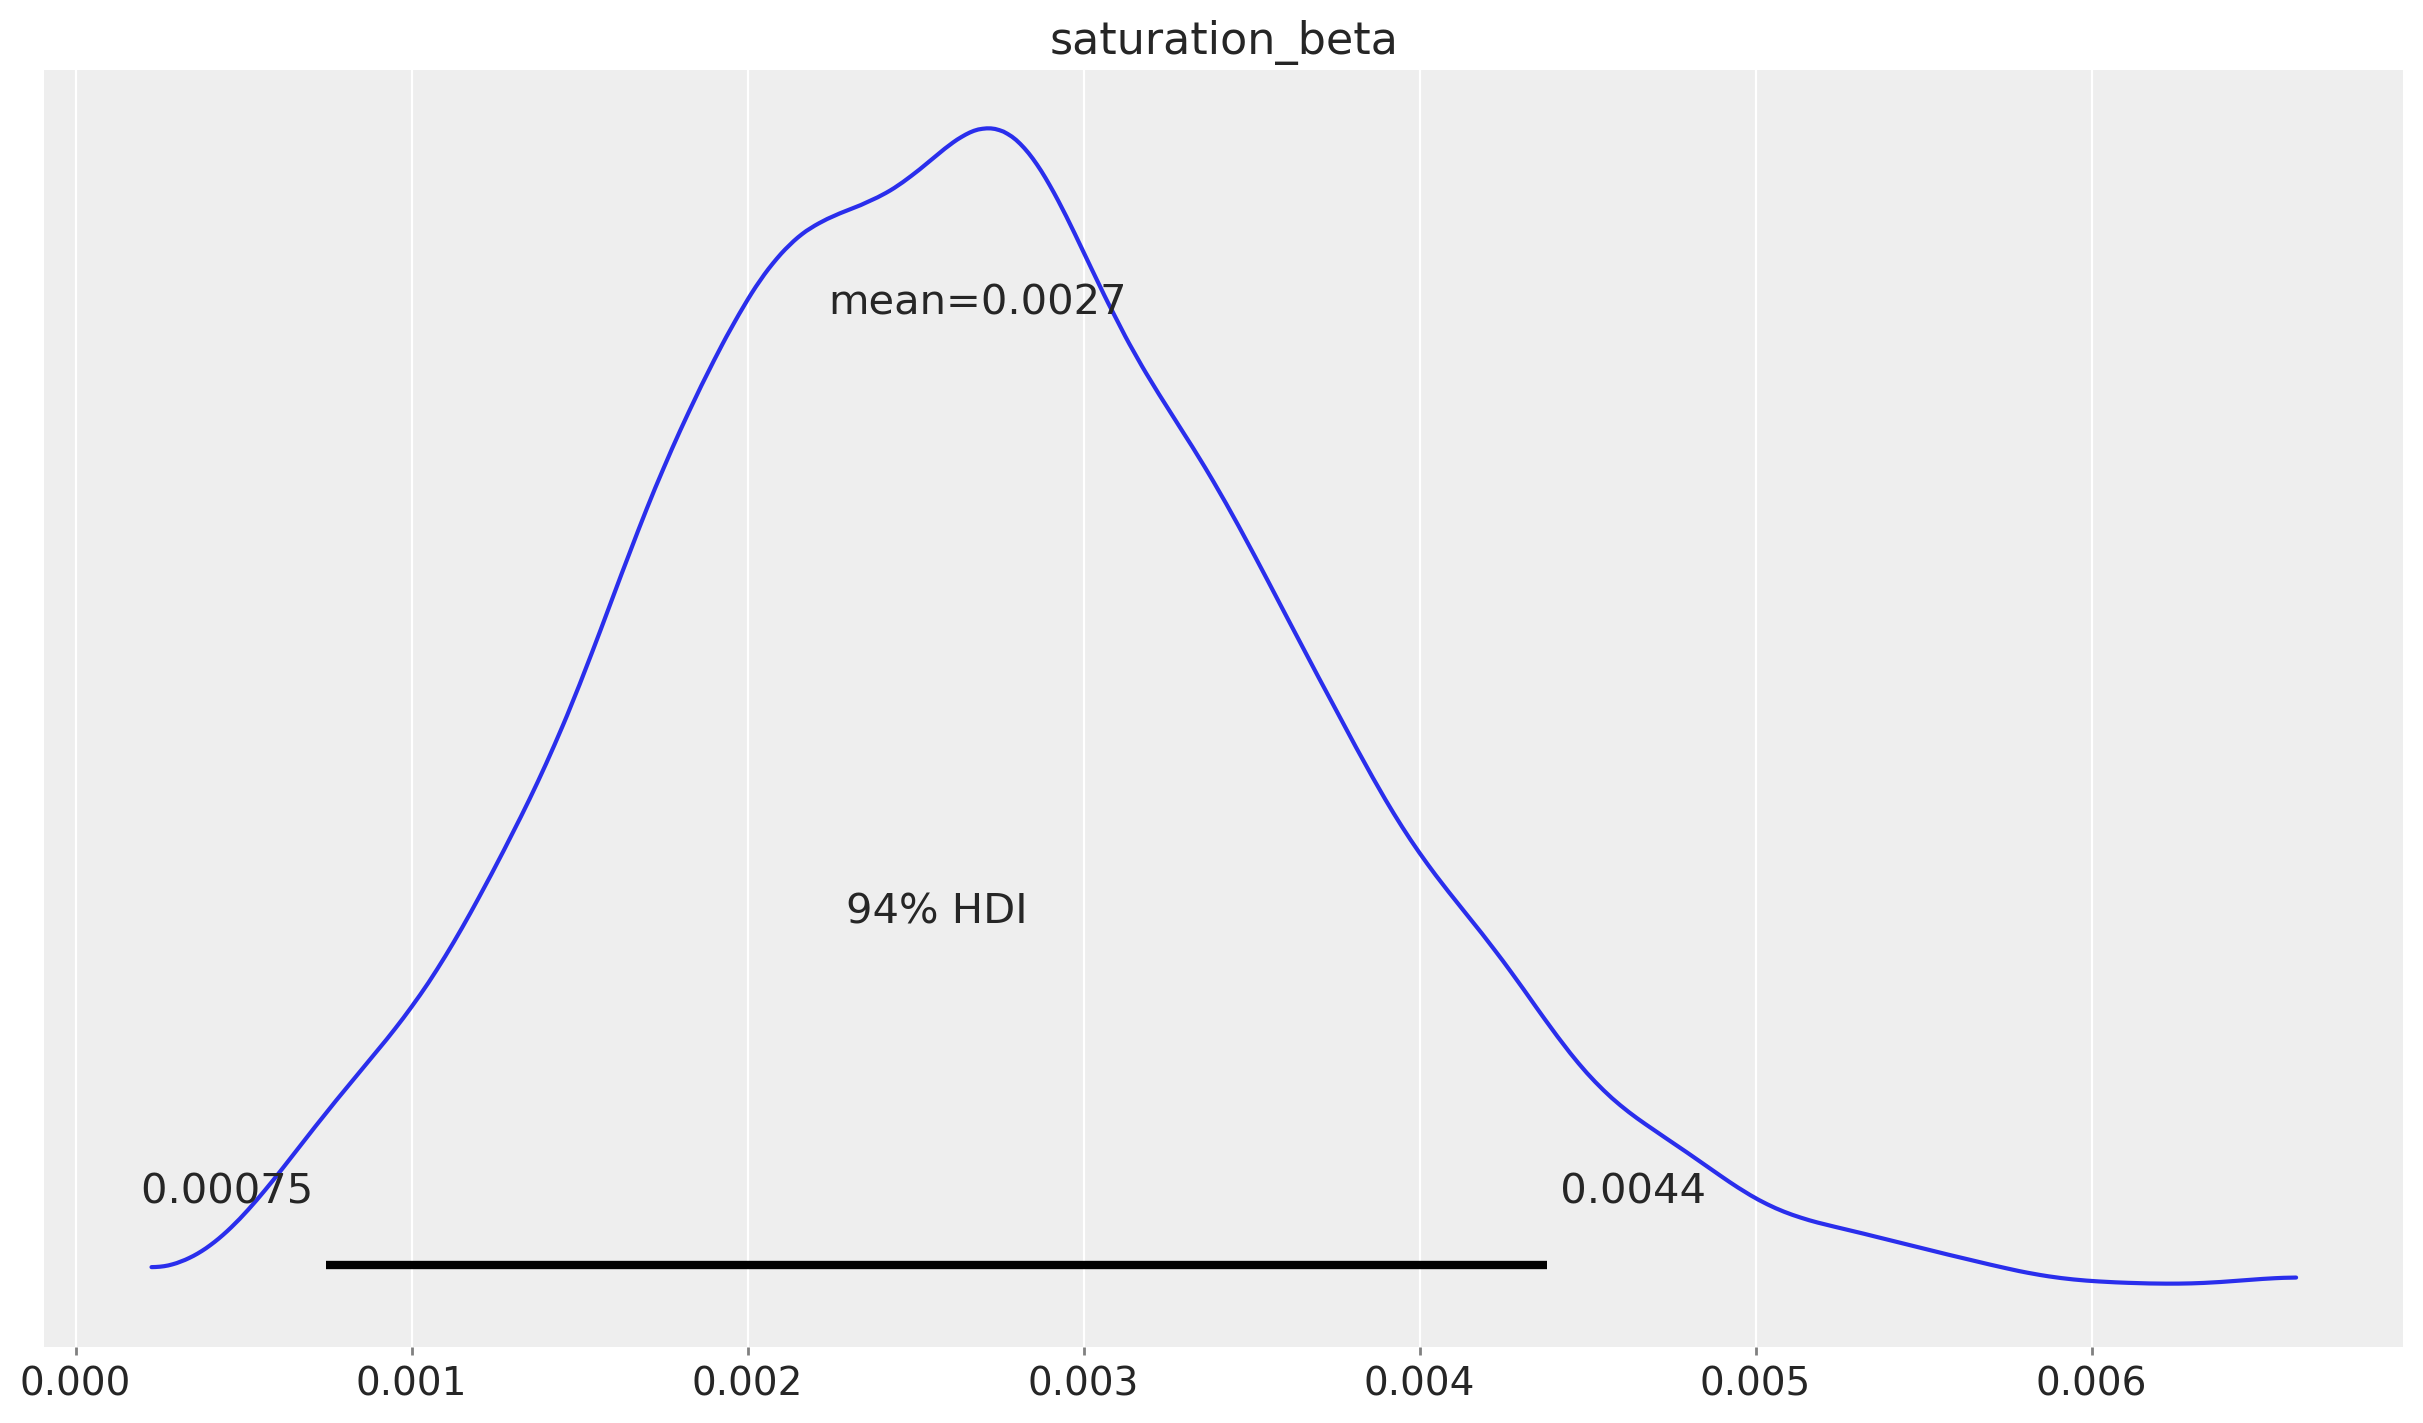

In [13]:
az.plot_posterior(
    second_causal_mmm.fit_result * second_causal_mmm.scalers._target.item(),
    var_names=["saturation_beta"],
);

As shown in the advanced notebook ({ref}`mmm_upper_funnel_causal_approach`), where we study the data generating process, the saturation parameter is correctly recovered.

Let's now look into the contribution of the upper funnel channel to the lower funnel channel.

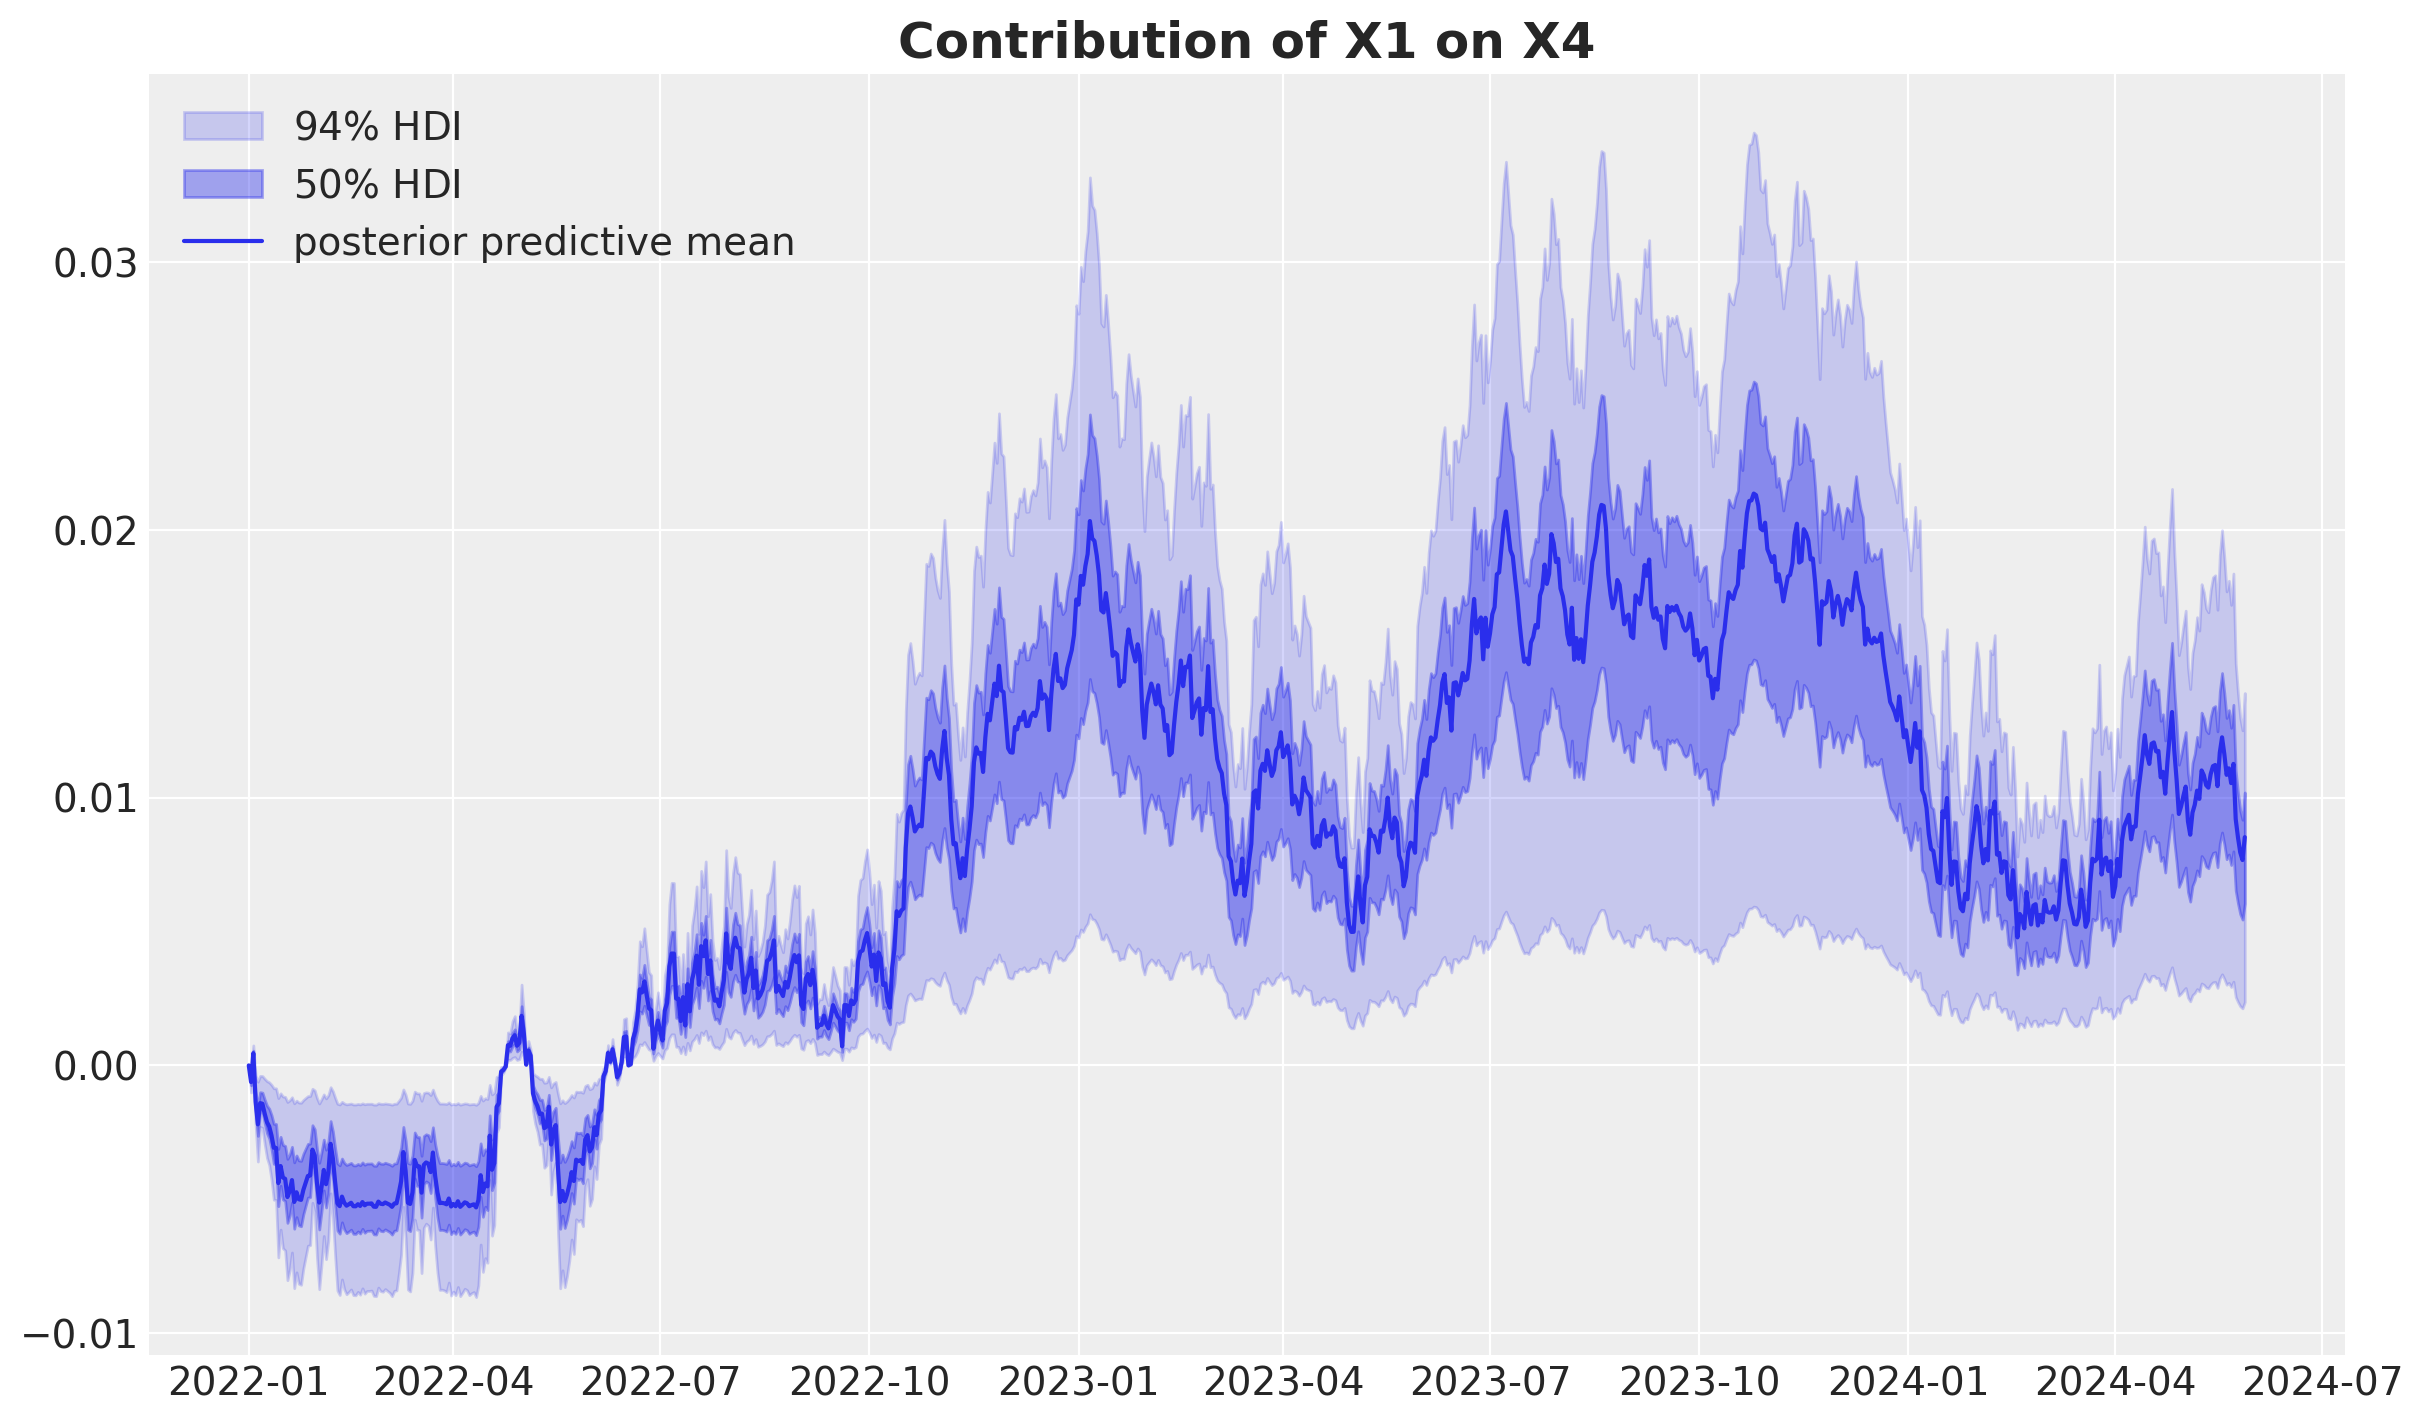

In [14]:
fig, ax = plt.subplots()

az.plot_hdi(
    X_train["date"],
    second_causal_mmm.fit_result["channel_contribution_original_scale"]
    .sel(channel="impressions_x1_diff")
    .cumsum(dim="date"),
    color="C0",
    hdi_prob=0.94,
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)

az.plot_hdi(
    X_train["date"],
    second_causal_mmm.fit_result["channel_contribution_original_scale"]
    .sel(channel="impressions_x1_diff")
    .cumsum(dim="date"),
    color="C0",
    hdi_prob=0.5,
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HDI"},
    ax=ax,
)

ax.plot(
    X_train["date"],
    second_causal_mmm.fit_result["channel_contribution_original_scale"]
    .sel(channel="impressions_x1_diff")
    .cumsum(dim="date")
    .mean(dim=("chain", "draw")),
    color="C0",
    label="posterior predictive mean",
)


ax.legend()
ax.set_title("Contribution of X1 on X4", fontsize=18, fontweight="bold");

Again, from the data generating process, this contribution is correctly estimated.

Finally, we can visualize the posterior predictive mean of the lower funnel channel.

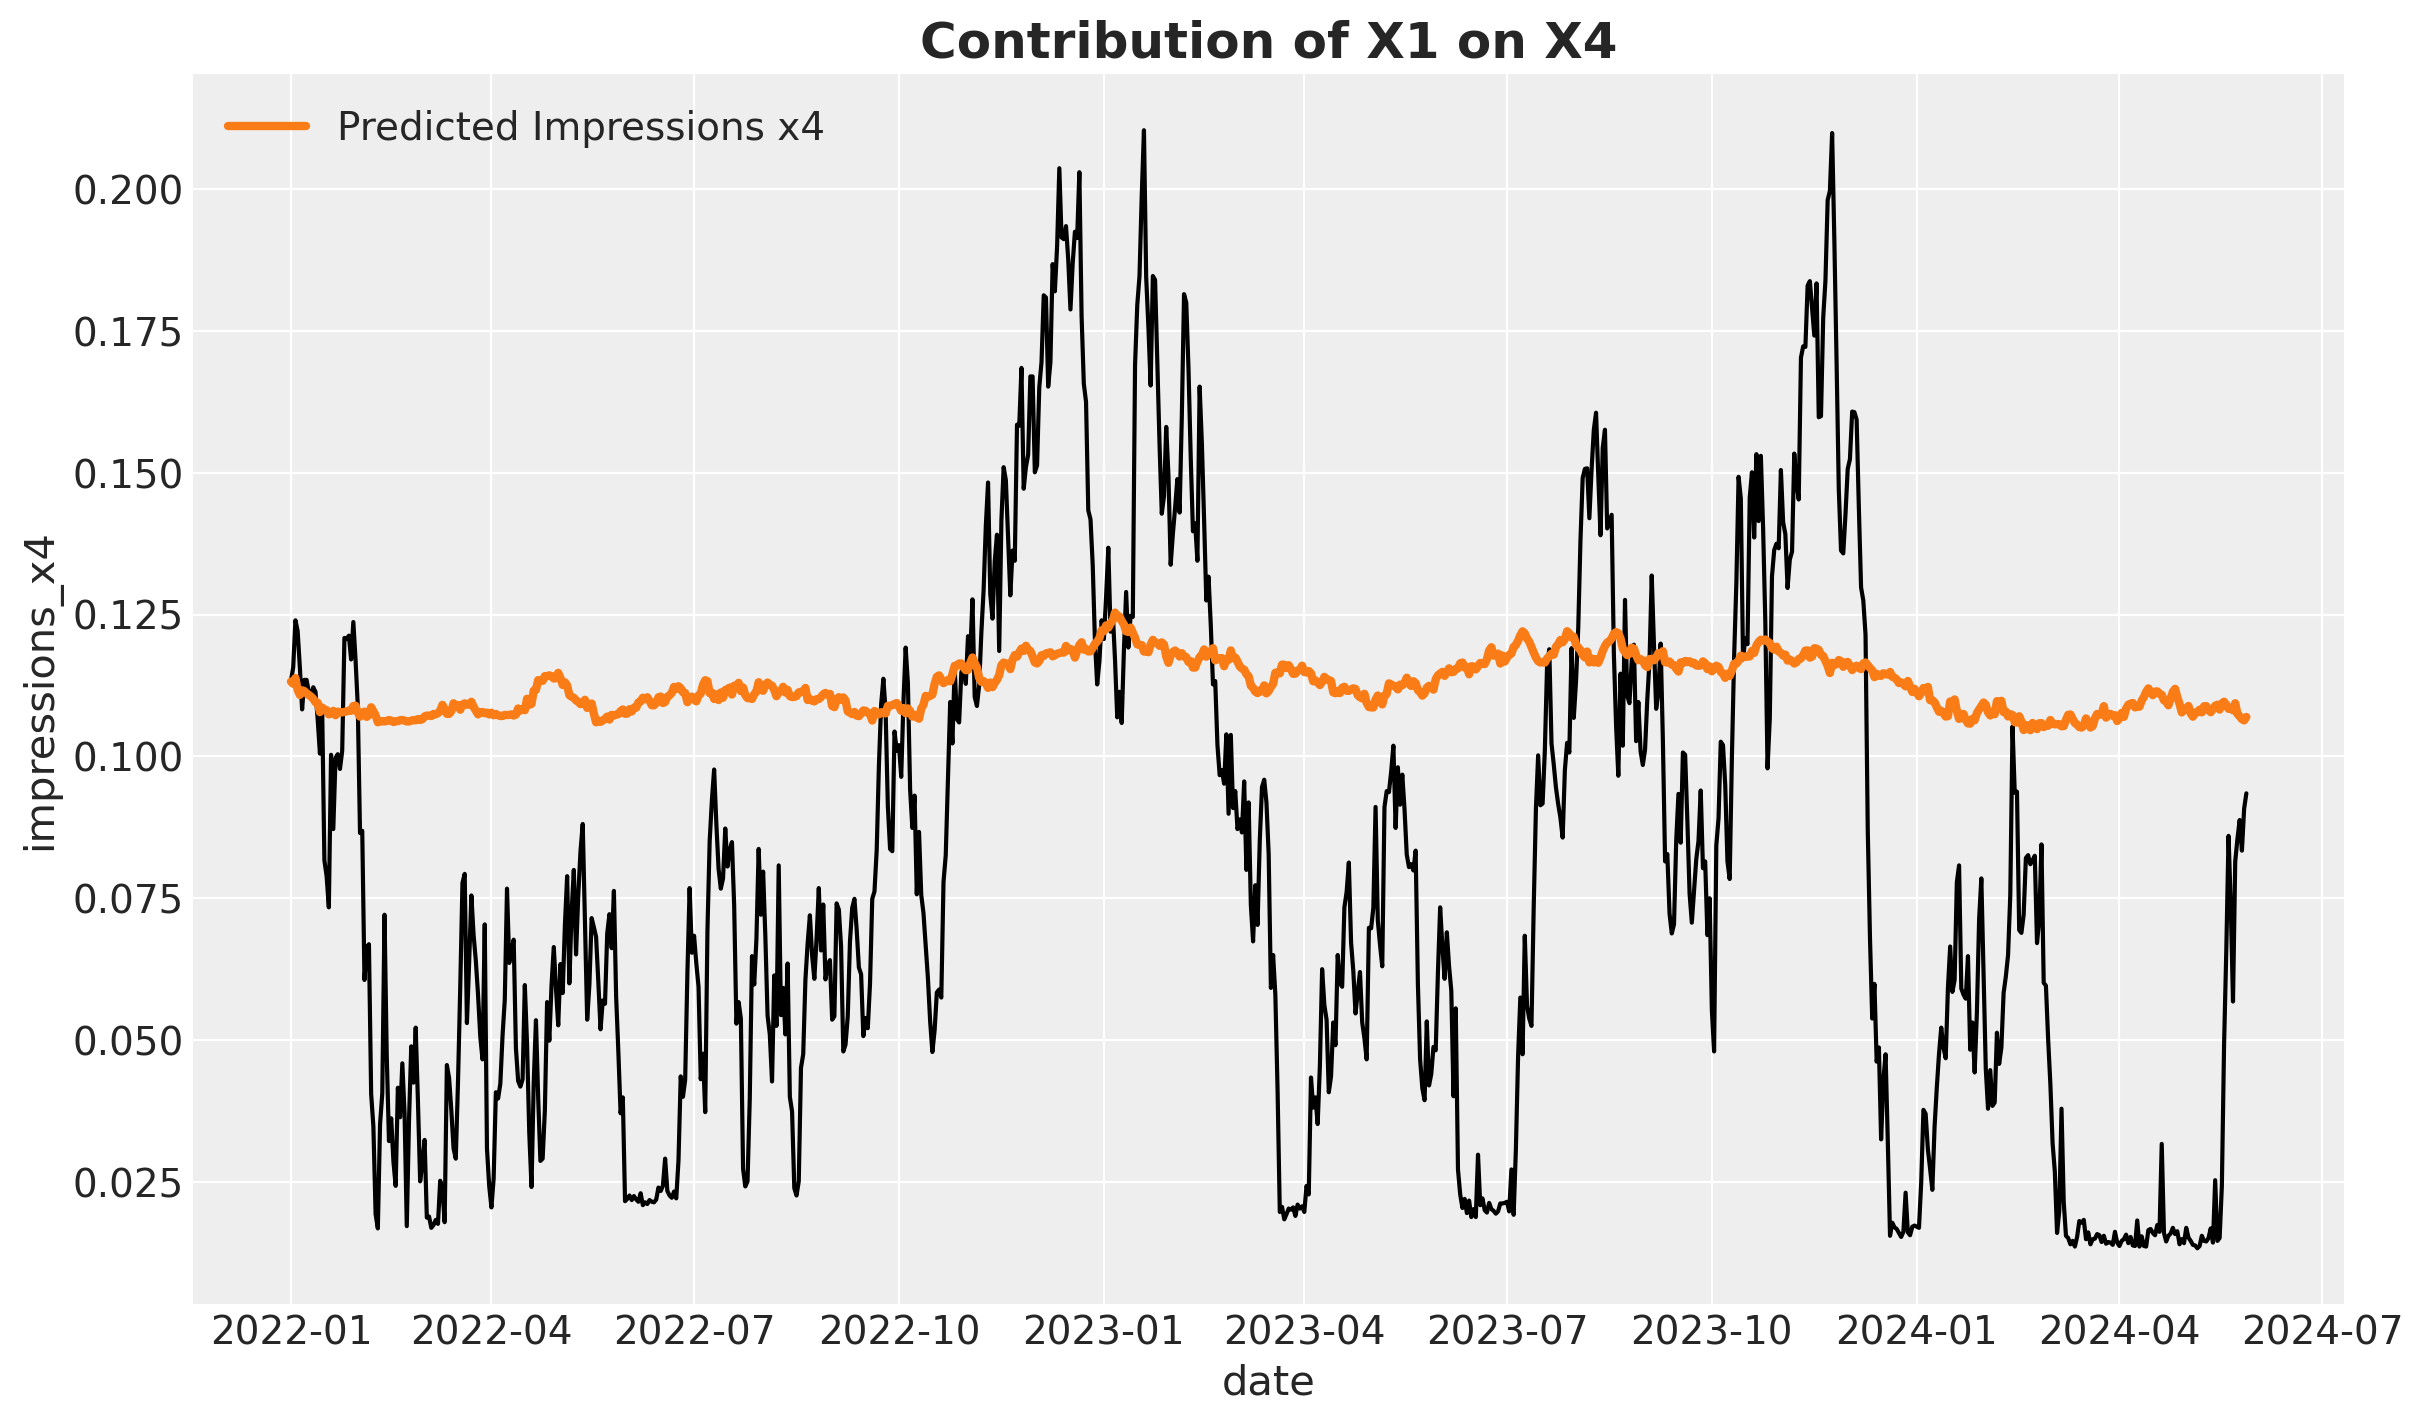

In [15]:
fig, ax = plt.subplots()

sns.lineplot(
    data=X_train,
    x="date",
    y="impressions_x4",
    color="black",
    ax=ax,
)

ax.plot(
    X_train["date"],
    (
        second_causal_mmm.fit_result["y_original_scale"]
        .cumsum(dim="date")
        .mean(dim=("chain", "draw"))
        + X_train["impressions_x4"].iloc[0]
    ),
    color="C1",
    label="Predicted Impressions x4",
    linewidth=3,
)

ax.legend()
ax.set_title("Contribution of X1 on X4", fontsize=18, fontweight="bold");

This baseline model is not fantastic, but it captures the general trend of the data.

Now that we have both fitted models, we can use them to make counterfactual predictions.

## Counterfactual Predictions

Now comes the key question: **What would have happened if we had set X1 to zero?** This is a **counterfactual prediction** — we use our models to simulate an intervention we didn't actually observe.

The causal effect of X1 on Y flows through this path:

$$X_1 \to X_4 \to Y$$

**Step-by-step counterfactual generation:**

1. **Intervene on X1**: Set `impressions_x1 = 0` and compute `impressions_x1_diff`
2. **Predict counterfactual X4**: Use the mediation model to predict what X4 would have been without X1
3. **Predict counterfactual Y**: Use the outcome model with the counterfactual X4 as input
4. **Calculate effect**: Compare predictions under $do(X_1=1)$ vs. $do(X_1=0)$

This approach is called **g-computation** or **mediation formula** in causal inference. We're propagating the intervention through each step of the causal chain, respecting the dynamic transformations (adstock, saturation) at each stage.

```{tip}
**Why does this work?** By modeling each link separately (X1→X4 and X4→Y), we can "block" X1's influence on X4, recompute X4, and see how that change ripples through to Y. The difference between the factual and counterfactual predictions is the **total causal effect** of X1 on Y.
```


Let's start setting `impressions_x1` to zero:

In [16]:
X_train_x1_zero_over_x4 = X_train.assign(
    impressions_x1=lambda df: np.zeros_like(df["impressions_x1"].to_numpy())
).assign(impressions_x1_diff=lambda df: df["impressions_x1"].diff().to_numpy())

Next, we used the fitted posterior to generate the counterfactual predictions:

In [17]:
posterior_contribution_x1_zero_over_x4 = second_causal_mmm.sample_posterior_predictive(
    X_train_x1_zero_over_x4,
    extend_idata=False,
    combined=False,
    var_names=["channel_contribution_original_scale", "y_original_scale"],
)

Sampling: [y]


Output()

We can now plot the posterior predictive mean of the lower funnel channel with the counterfactual predictions and compare them with the original predictions.

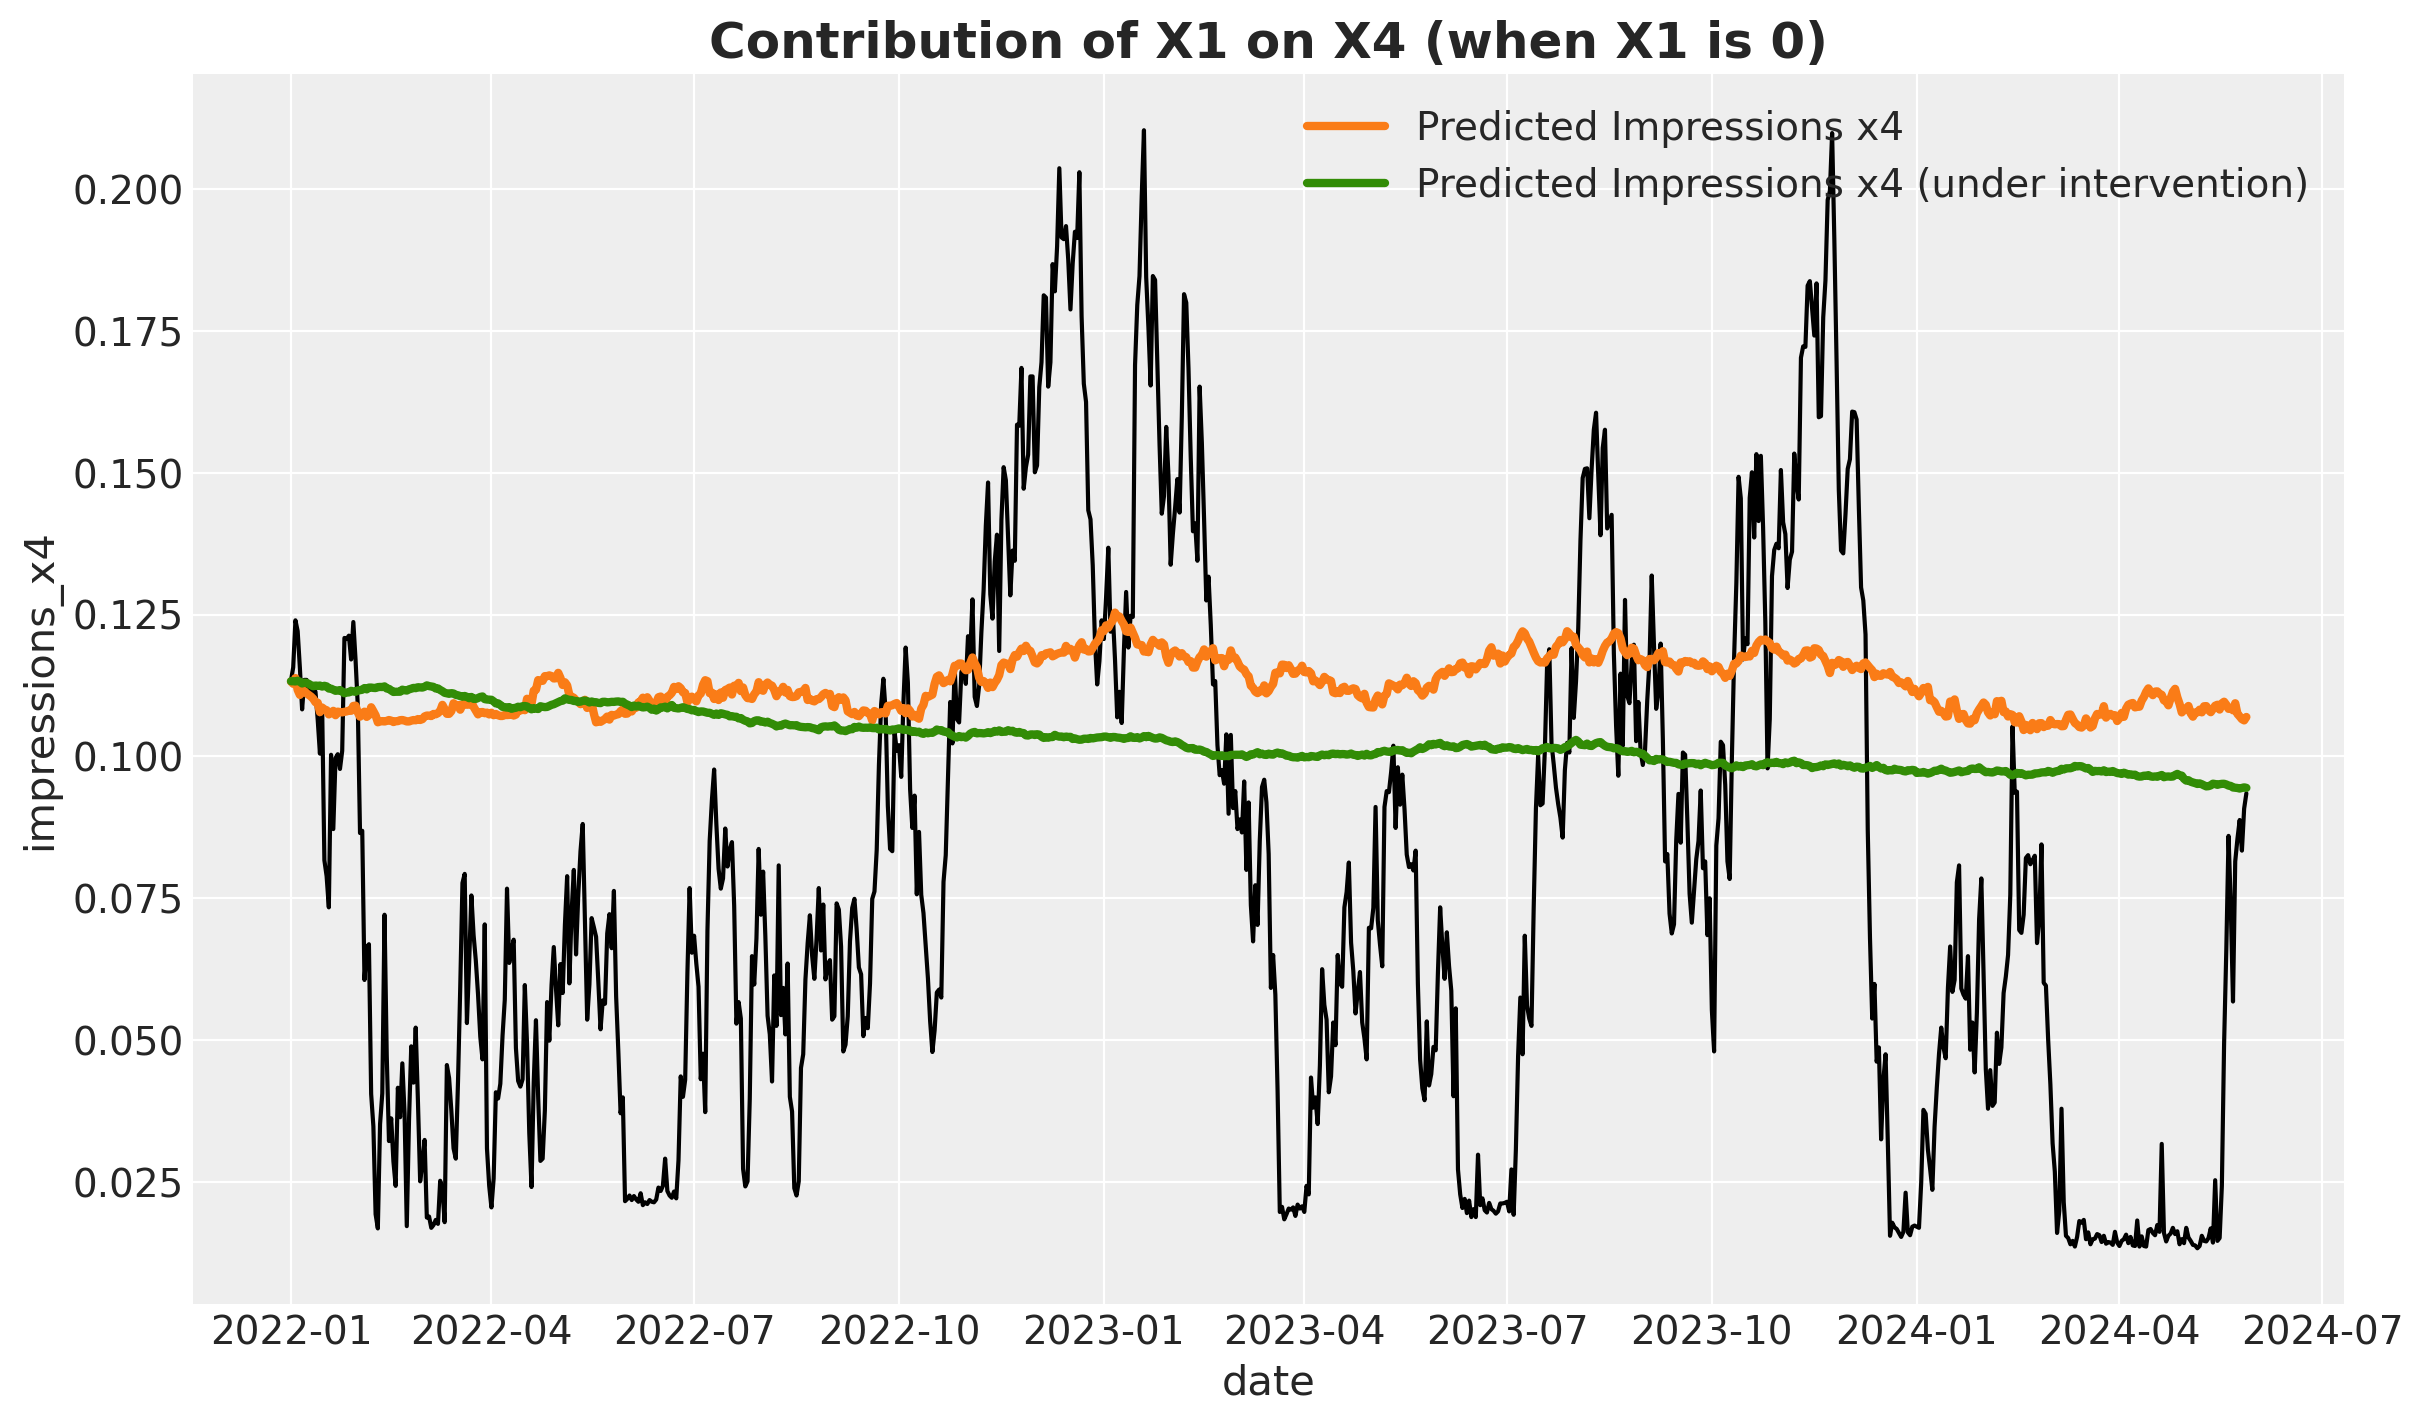

In [18]:
fig, ax = plt.subplots()

sns.lineplot(
    data=X_train,
    x="date",
    y="impressions_x4",
    color="black",
    ax=ax,
)

ax.plot(
    X_train["date"],
    (
        second_causal_mmm.fit_result["y_original_scale"]
        .cumsum(dim="date")
        .mean(dim=("chain", "draw"))
        + X_train["impressions_x4"].iloc[0]
    ),
    color="C1",
    label="Predicted Impressions x4",
    linewidth=3,
)

ax.plot(
    X_train["date"],
    (
        posterior_contribution_x1_zero_over_x4["y_original_scale"]
        .cumsum(dim="date")
        .mean(dim=("chain", "draw"))
        + X_train["impressions_x4"].iloc[0]
    ),
    color="C2",
    label="Predicted Impressions x4 (under intervention)",
    linewidth=3,
)

ax.legend()
ax.set_title("Contribution of X1 on X4 (when X1 is 0)", fontsize=18, fontweight="bold");

As expected, on average most of the predicted impressions under the counterfactual are lower than the original predictions.

We now use these predictions to make counterfactual predictions for the outcome.

In [19]:
target_posterior_predictive_original = first_causal_mmm.sample_posterior_predictive(
    X_train.assign(
        impressions_x4=(
            second_causal_mmm.fit_result["y_original_scale"]
            .cumsum(dim="date")
            .mean(dim=("chain", "draw"))
            + X_train["impressions_x4"].iloc[0]
        ),
    ),
    extend_idata=False,
    combined=False,
)

target_posterior_predictive_x1_zero = first_causal_mmm.sample_posterior_predictive(
    X_train.assign(
        impressions_x4=(
            posterior_contribution_x1_zero_over_x4["y_original_scale"]
            .cumsum(dim="date")
            .mean(dim=("chain", "draw"))
            + X_train["impressions_x4"].iloc[0]
        ),
    ),
    extend_idata=False,
    combined=False,
)

Sampling: [y]


Output()

Sampling: [y]


Output()

Let's visualize the results:

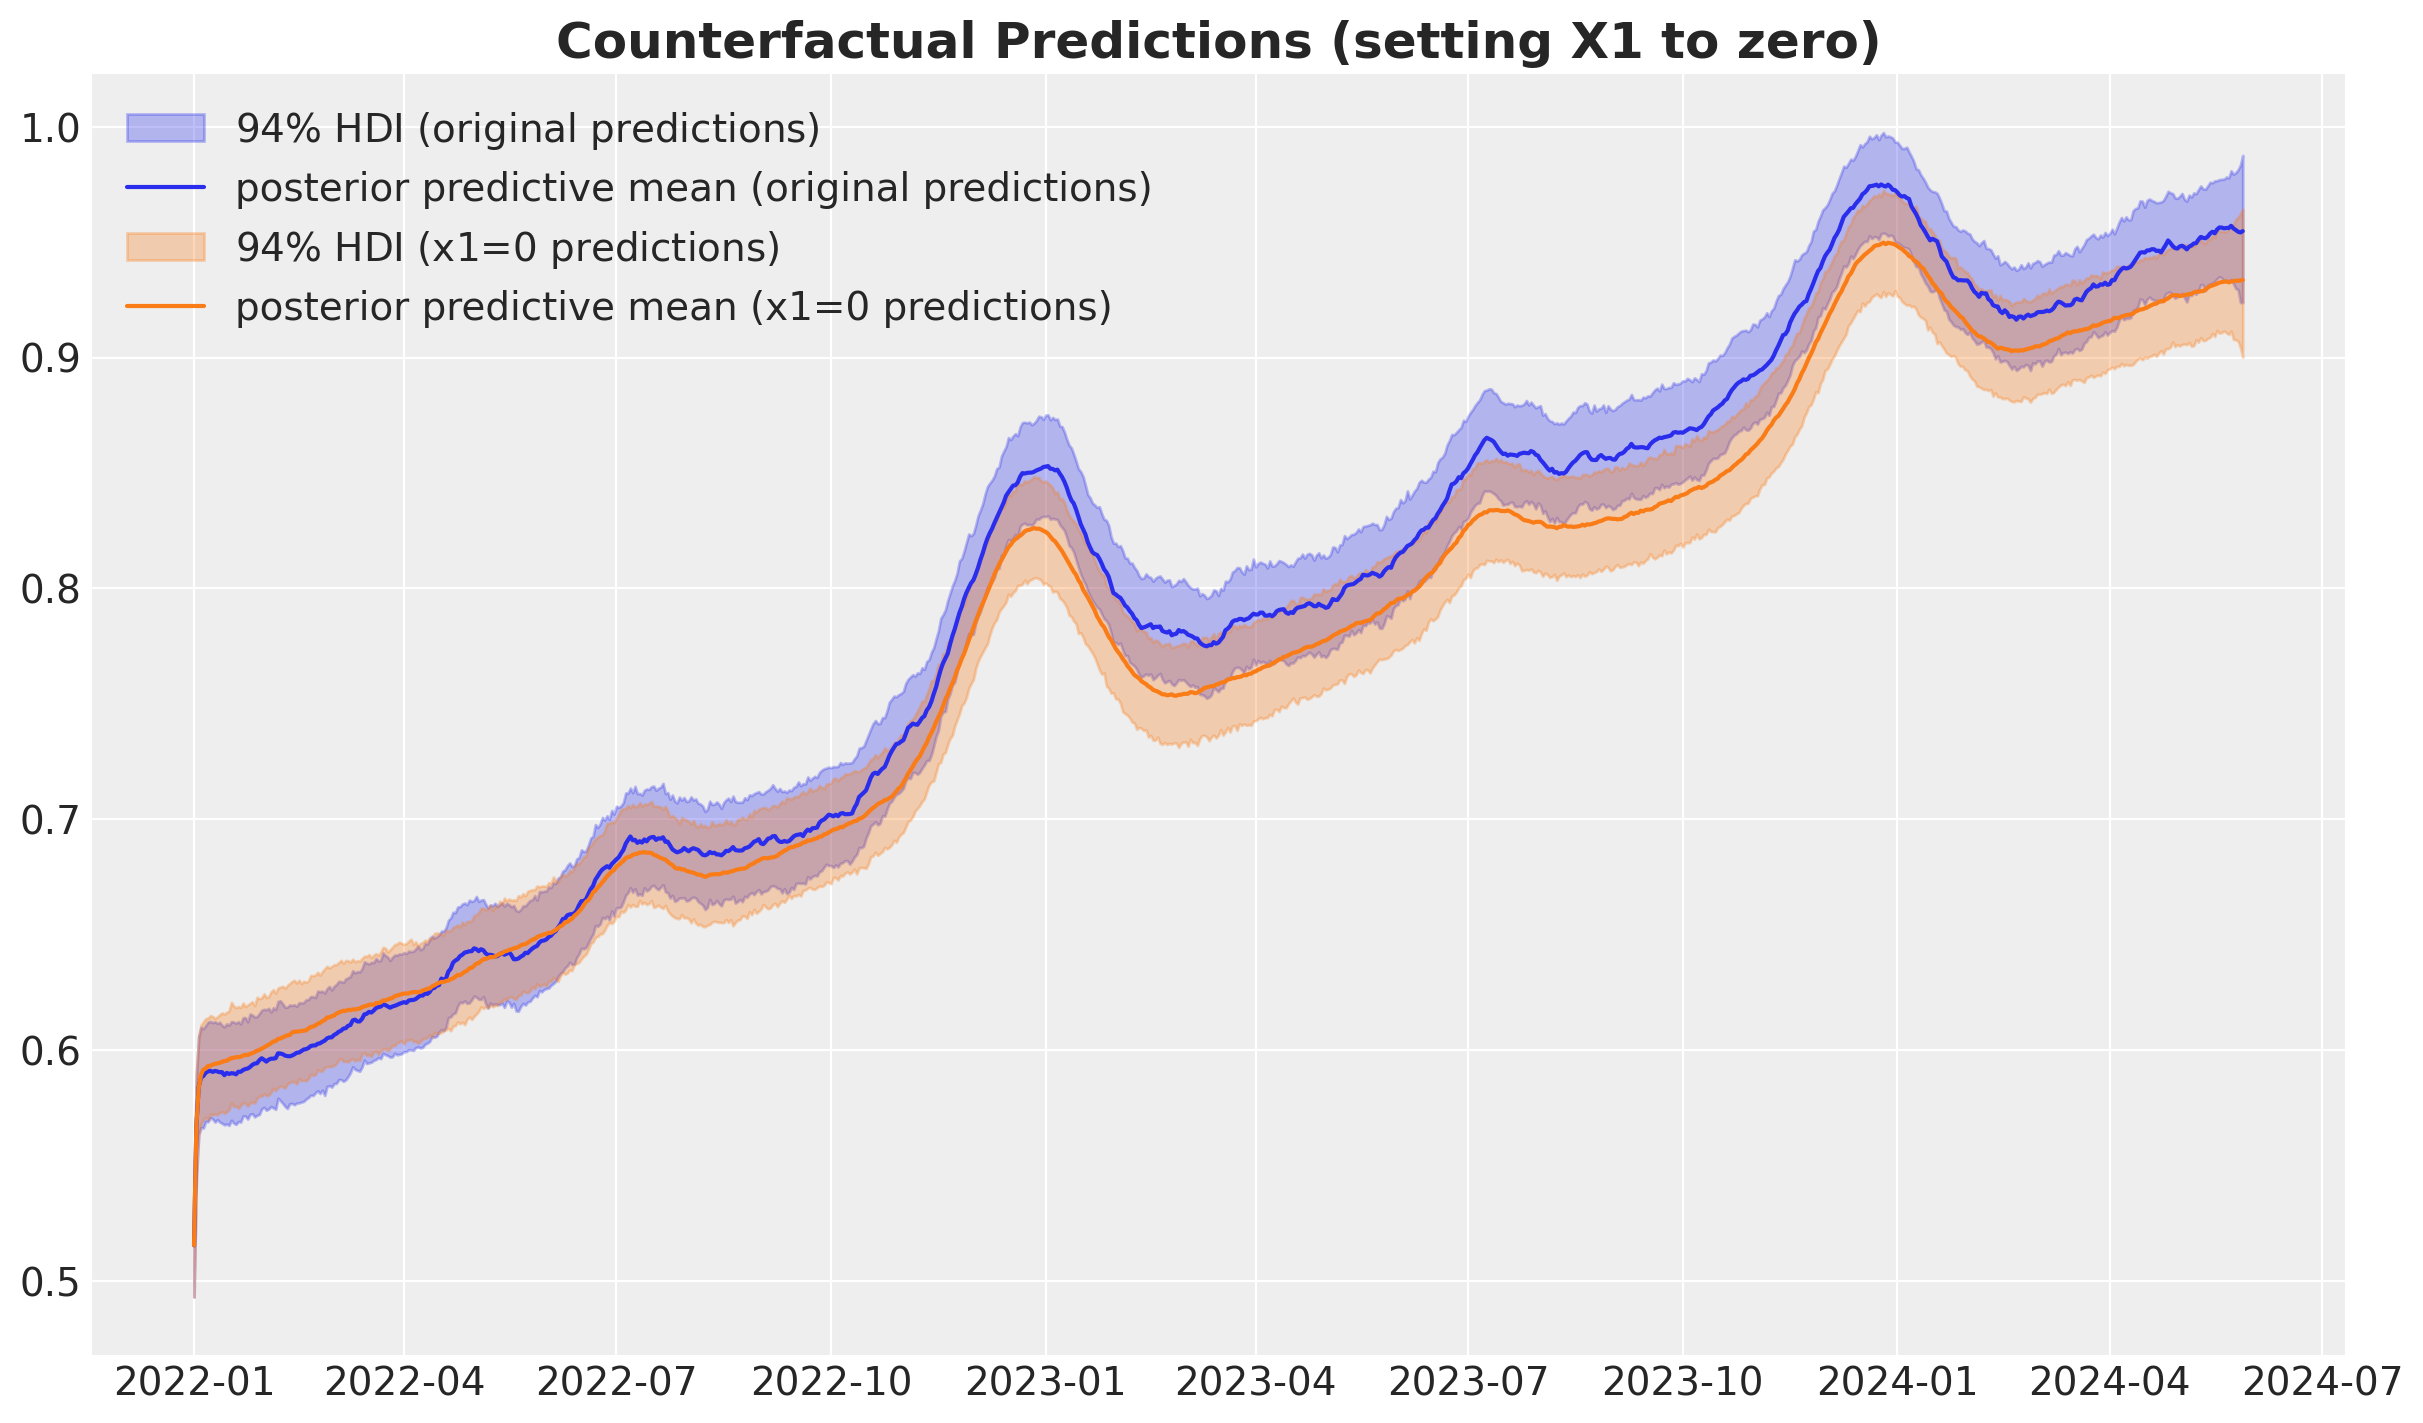

In [20]:
fig, ax = plt.subplots()

az.plot_hdi(
    X_train["date"],
    target_posterior_predictive_original["y_original_scale"],
    color="C0",
    hdi_prob=0.94,
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI (original predictions)"},
    smooth=False,
    ax=ax,
)

ax.plot(
    X_train["date"],
    target_posterior_predictive_original["y_original_scale"].mean(
        dim=("chain", "draw")
    ),
    color="C0",
    label="posterior predictive mean (original predictions)",
)

az.plot_hdi(
    X_train["date"],
    target_posterior_predictive_x1_zero["y_original_scale"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI (x1=0 predictions)"},
    smooth=False,
    ax=ax,
)

ax.plot(
    X_train["date"],
    target_posterior_predictive_x1_zero["y_original_scale"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior predictive mean (x1=0 predictions)",
)

ax.legend()
ax.set_title(
    "Counterfactual Predictions (setting X1 to zero)", fontsize=18, fontweight="bold"
);

Finally, we can calculate the difference between the original and counterfactual predictions and visualize the results:

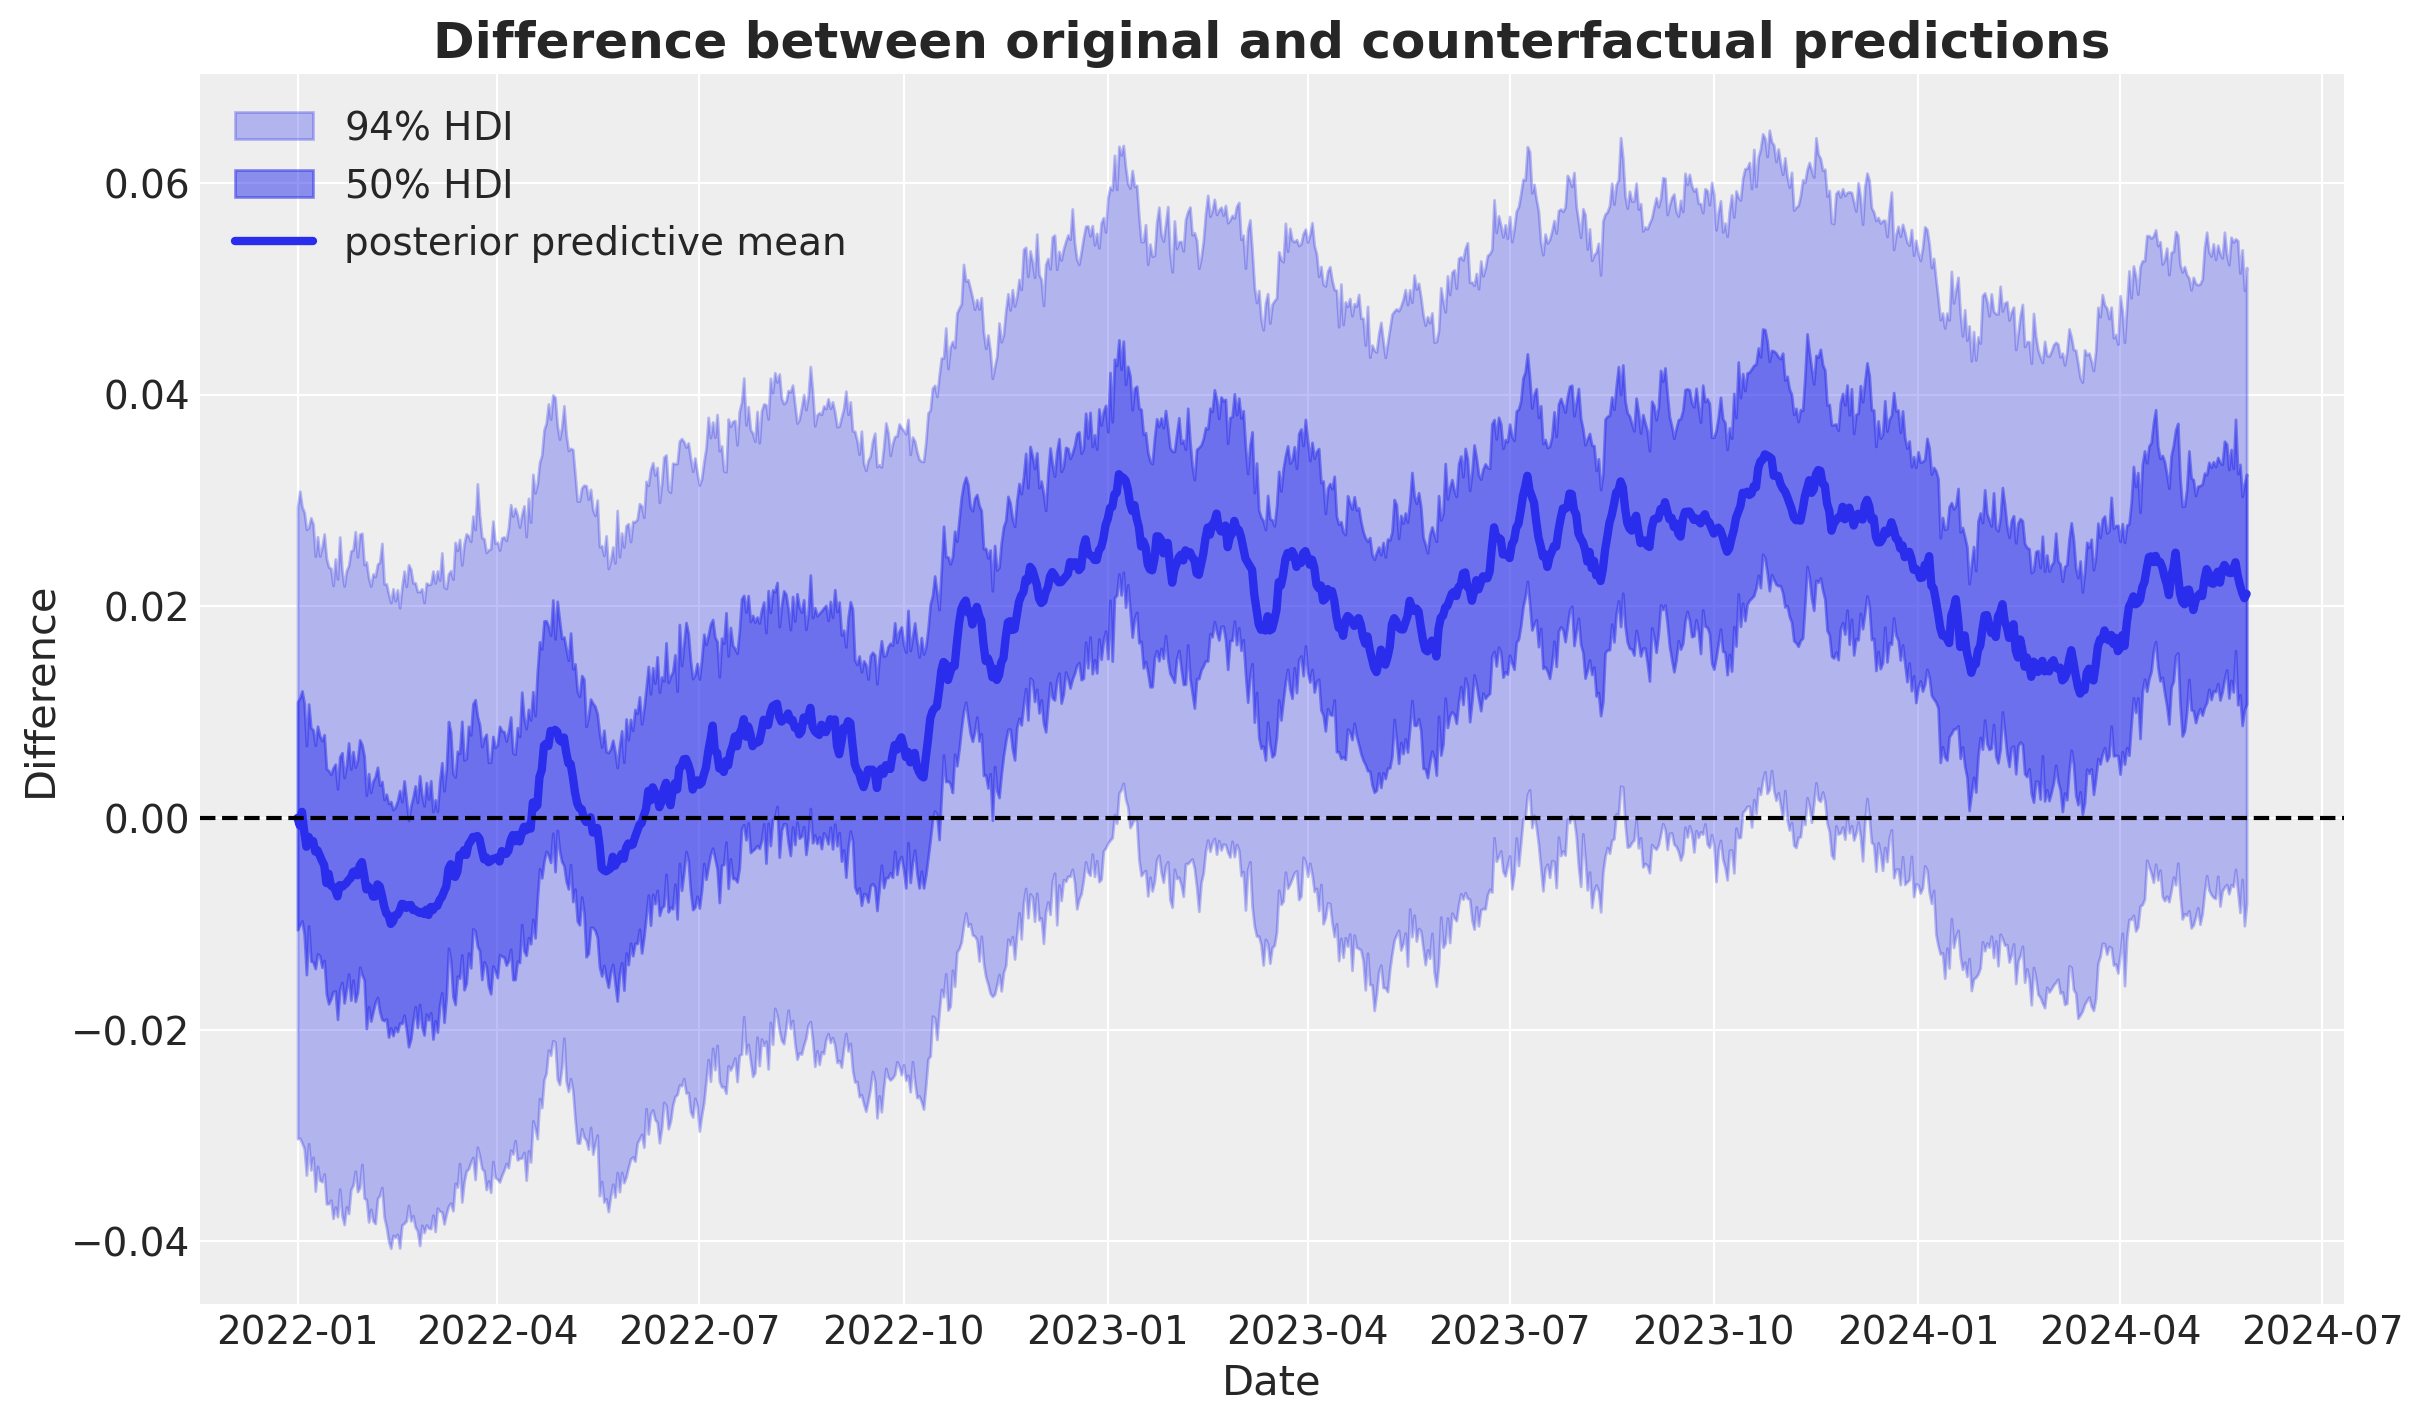

In [21]:
difference = (
    target_posterior_predictive_original["y_original_scale"]
    - target_posterior_predictive_x1_zero["y_original_scale"]
)

fig, ax = plt.subplots()

az.plot_hdi(
    X_train["date"],
    difference,
    color="C0",
    hdi_prob=0.94,
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    X_train["date"],
    difference,
    color="C0",
    hdi_prob=0.5,
    smooth=False,
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)

ax.plot(
    X_train["date"],
    difference.mean(dim=("chain", "draw")),
    color="C0",
    label="posterior predictive mean",
    linewidth=3,
)

ax.axhline(0, color="black", linestyle="--")
ax.legend()
ax.set(xlabel="Date", ylabel="Difference")
ax.set_title(
    "Difference between original and counterfactual predictions",
    fontsize=18,
    fontweight="bold",
);

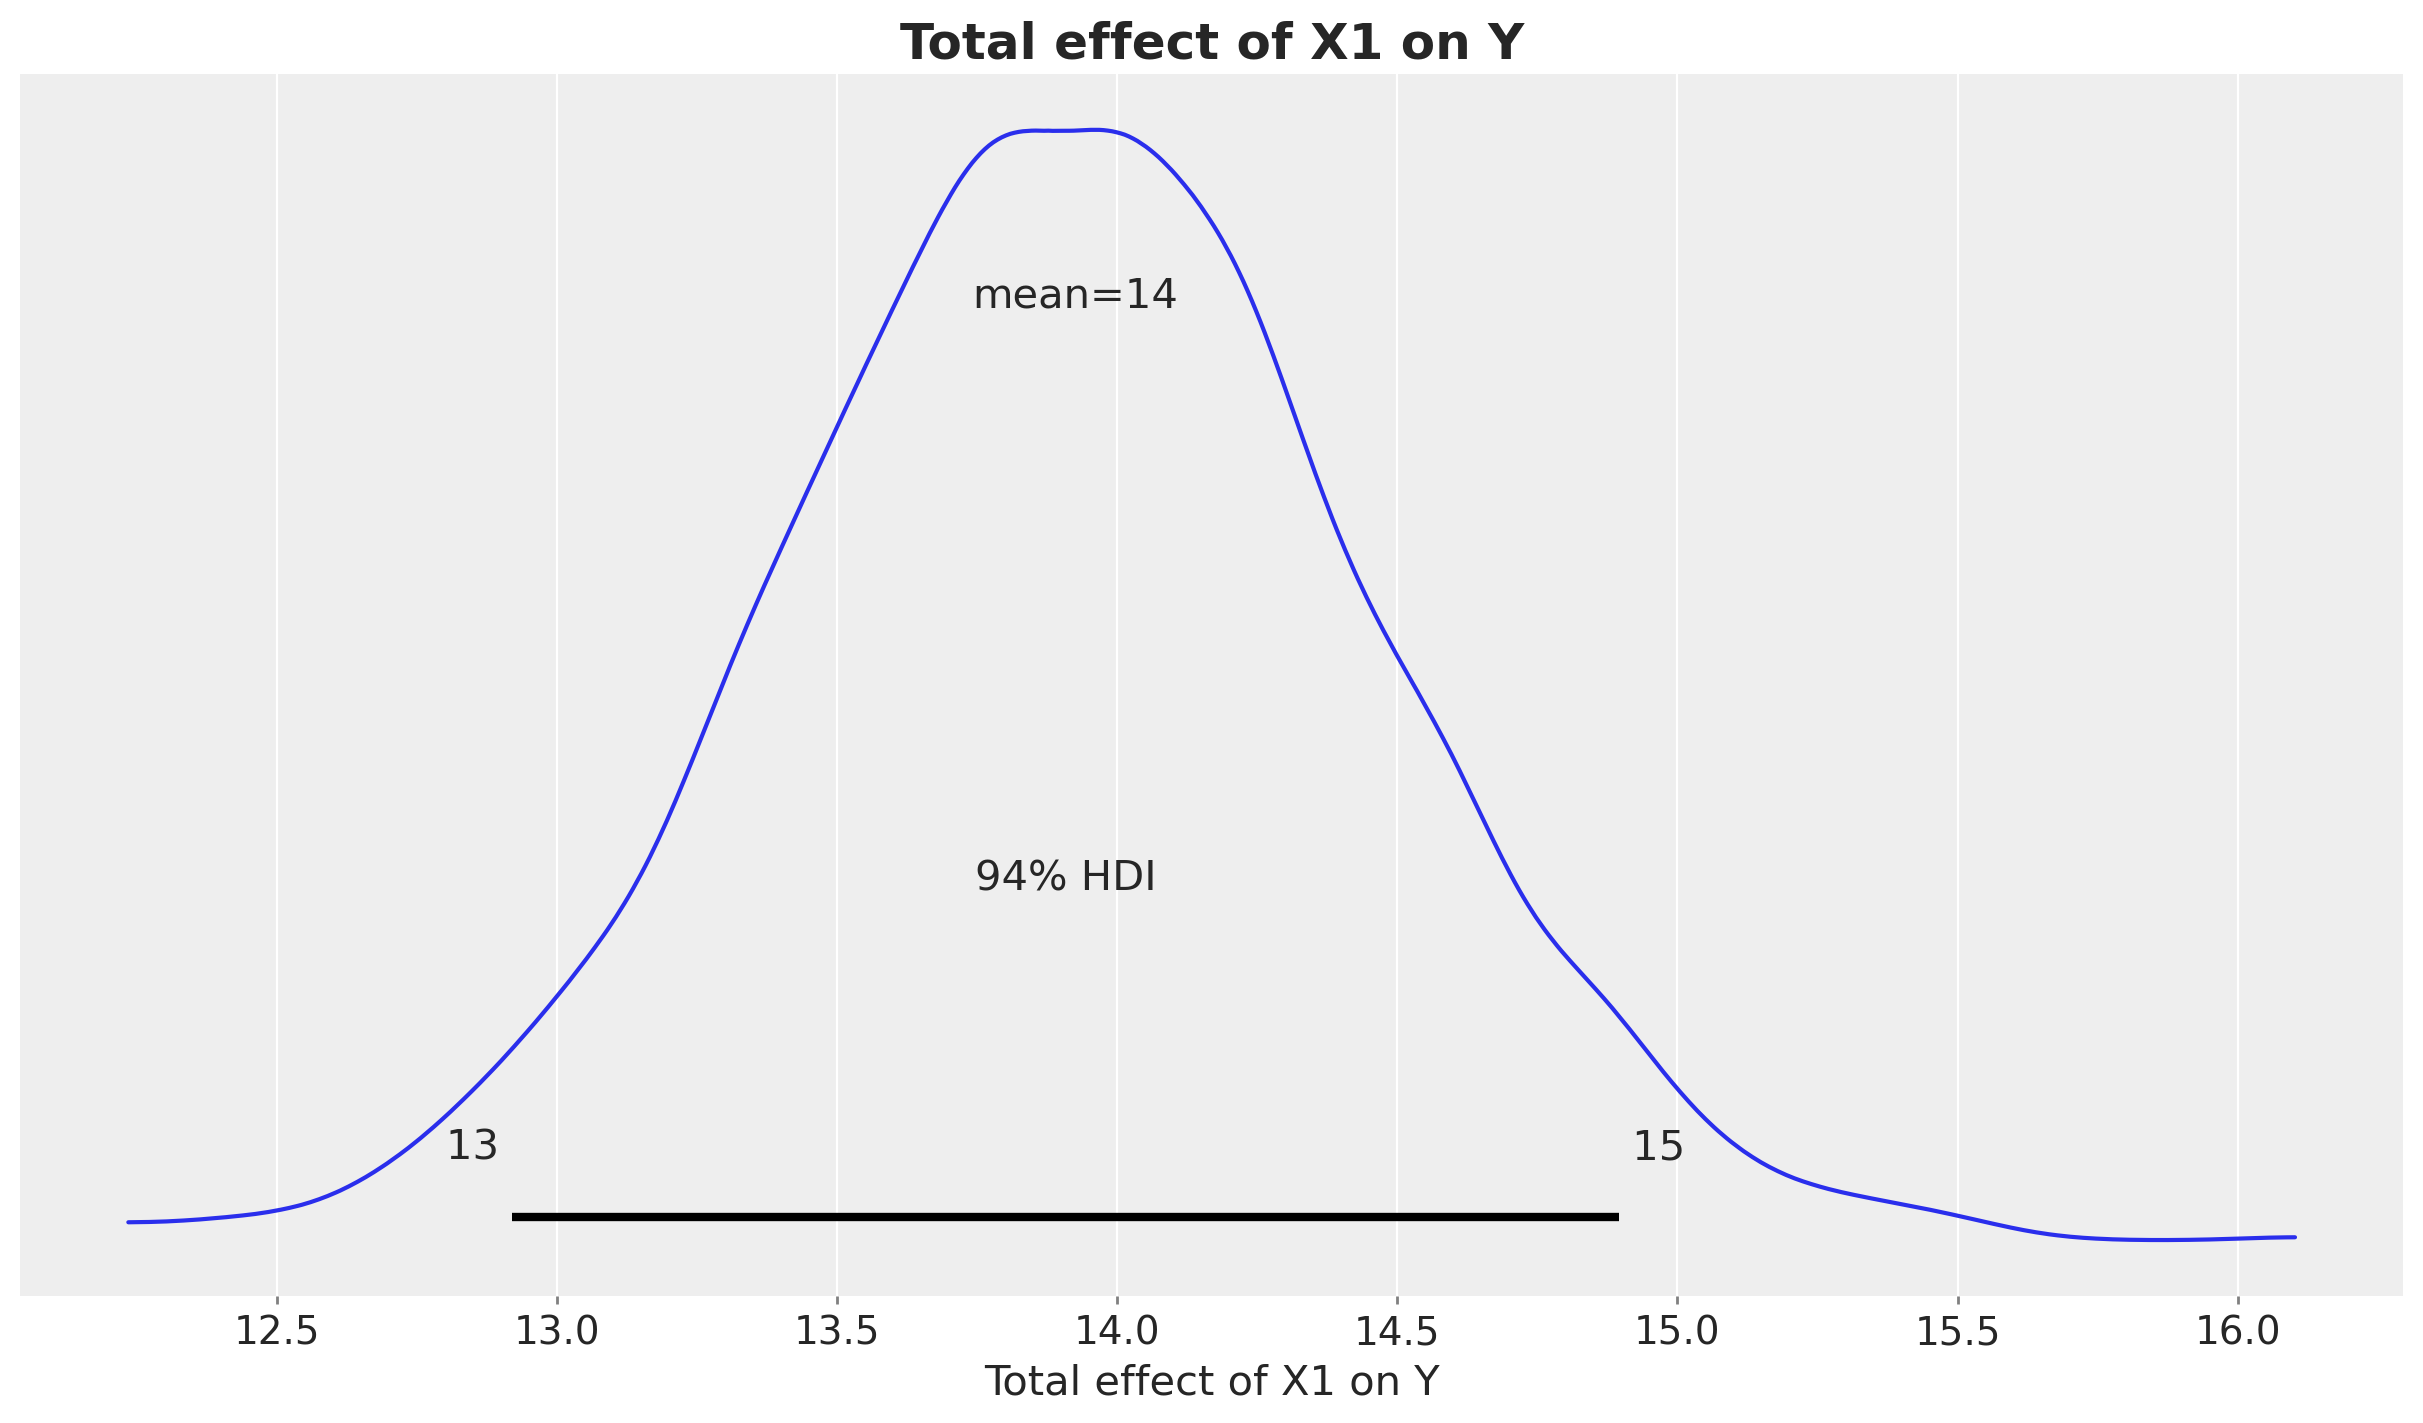

In [22]:
fig, ax = plt.subplots()
az.plot_posterior(difference.sum(dim="date"), ax=ax)
ax.set(xlabel="Total effect of X1 on Y")
ax.set_title("Total effect of X1 on Y", fontsize=18, fontweight="bold");

## Conclusion

In this notebook, we demonstrated how to measure **indirect upper-funnel effects** using a mediation modeling approach. The key insights are:

1. **Respect causal structure**: Upper-funnel channels often don't directly affect outcomes. Their influence flows through intermediate channels (mediators).

2. **Two-model approach**: By separating the mediation model (X1→X4) from the outcome model (X4→Y), we can correctly attribute effects without confounding.

3. **Counterfactual reasoning**: To answer "what would happen if we changed X1?", we propagate the intervention through each link of the causal chain: $X_1 \to X_4 \to Y$.

4. **Dynamic effects matter**: The outcome model includes adstock and saturation because marketing effects carry over time and show diminishing returns.

**Key takeaway:** Standard MMMs that throw all channels into one model will misattribute upper-funnel contributions. A causal approach that models the funnel structure explicitly gives more accurate and defensible effect estimates.

For a comprehensive treatment including:
- Detailed data generation process
- Theoretical foundations (backdoor criterion, structural causal models)
- Comparison with naive "all-in" models
- Out-of-sample validation

see the advanced version: {ref}`mmm_upper_funnel_causal_approach`.


In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing

Last updated: Mon Nov 17 2025

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.6.0

pymc_marketing: 0.17.0

pymc_marketing: 0.17.0
arviz         : 0.22.0
graphviz      : 0.21
pandas        : 2.3.3
pymc_extras   : 0.5.0
matplotlib    : 3.10.7
seaborn       : 0.13.2
numpy         : 2.3.4

Watermark: 2.5.0

